### This is a library to find the best performing configuration from a set of dimensions (i.e. schemas, partition, storage) which can be specified inside the <b>settings.yaml</b> file in the resource

In [ ]:
%pip install PAPyA==0.1.0

### Load the configuration file and log files location for the experiment

<p>Configurations for SP2Bench Data</p>

In [6]:
config_sp2bench = "settings.yaml" # config file location
logs_sp2bench = "log" # logs file location

<p>Configurations for Watdiv Data</p>

In [6]:
config_watdiv = "settings_watdiv.yaml" # config file location
logs_watdiv = "log_watdiv" # logs file location

#### <u>Configuration file</u> <br>
The configuration file is a yaml data-serialization language which has two main parts, the dimensions and the number of query experiments. You can add more dimensions here or change these existing dimensions to anything you need

<i>Example :</i> 
```yaml
dimensions:
    schemas: ["st", "vt", "pt"]
    partition: ["horizontal", "subject"]
    storage: ["parquet", "orc"]

query: 20
```

#### <u>Log file structure</u> <br>
the structure of the log files must follow the order of dimensions in the configuration file (i.e. {schemas}.{partition}.{storage}.txt) and the subfolders should be the ranking sets of the experiments (i.e. dataset sizes)

<i>Example :</i>
```
UI Module
└───log
    │
    |───100M
    |    │   st.horizontal.csv.txt
    |    │   st.horizontal.avro.txt
    |    │   ...
    │
    └───250M
        |   st.horizontal.csv.txt
        │   st.horizontal.avro.txt
        │   ...
```

### Single Dimensional Ranking

<b>SDRank</b> is a class module from PAPyA library to calculate ranking score _R_ for each dimension independently that operates over a log-based structure that user specified on the configuration file.<br> 
The value of _R_ represents the performance of a particular configuration (higher value means better performing configuration). We used Ranking Function _R_ below to calculate the rank scores:

$$R =\sum \limits _{r=1} ^{d} \frac{O_{dim} * (d-r)}{|Q| * (d-1)}, 0<R<=1$$

$d$         : total number of parameters (options) in a particular dimension<br>
$O_{dim}$   : number of occurences of the dimension placed at rank $r$ (Rank 1, Rank 2, Rank 3, ...)<br>
$|Q|$       : total number of queries

### PAPyA.Rank.SDRank

#### <i>class</i> Rank.<b>SDRank</b>(<i>config_path, log_path, ranking_sets, dimension</i>)
<i>Parameters:</i> <br>
&emsp; <b>config_path : str</b><br>
&emsp;&emsp;<small>Specify the path to your configuration file(s). <i>i.e ./UIModule/settings_watdiv.yaml</small></i><br>
&emsp;<b>log_path : str</b><br>
&emsp;&emsp;<small>Specify the path to your log file(s). <i>i.e ./UI Module/log_watdiv</small></i><br>
&emsp;<b>ranking_sets : str</b><br>
&emsp;&emsp;<small>Ranking sets of user choice. <i>i.e dataset sizes (100M)</small></i><br>
&emsp;<b>dimension : str</b><br>
&emsp;&emsp;<small>A single dimension to be ranked. <i>i.e schemas</small></i><br>


In [7]:
# this class takes single dimension and dataset sizes as parameters that user specified inside their log files
from Rank import SDRank

schemaSDRank_100M = SDRank(config_watdiv, logs_watdiv, '100M', 'schemas')
schemaSDRank_250M = SDRank(config_watdiv, logs_watdiv, '250M', 'schemas')
schemaSDRank_500M = SDRank(config_watdiv, logs_watdiv, '500M', 'schemas')
partitionSDRank_100M = SDRank(config_watdiv, logs_watdiv, '100M', 'partition')
partitionSDRank_250M = SDRank(config_watdiv, logs_watdiv, '250M', 'partition')
partitionSDRank_500M = SDRank(config_watdiv, logs_watdiv, '500M', 'partition')
storageSDRank_100M = SDRank(config_watdiv, logs_watdiv, '100M', 'storage')
storageSDRank_250M = SDRank(config_watdiv, logs_watdiv, '250M', 'storage')
storageSDRank_500M = SDRank(config_watdiv, logs_watdiv, '500M', 'storage')

In [5]:
65/(20*4)

0.8125

In [10]:
SDRank(config_watdiv, logs_watdiv, '100M', 'storage').calculateRank('parquet')

,Rank 1,Rank 2,Result
extvp.horizontal.parquet,16.0,4.0,0.80
extvp.subject.parquet,13.0,7.0,0.65
vp.horizontal.parquet,13.0,7.0,0.65
vp.subject.parquet,8.0,12.0,0.40
st.horizontal.parquet,4.0,16.0,0.20
st.subject.parquet,1.0,19.0,0.05


In [11]:
12/20

0.6

In [1]:
from Rank import SDRank
SDRank('settings_watdiv.yaml', 'log_watdiv', '100M', 'schemas').replicability()

[[0.8125, 0.8, 0.8625], [0.9166666666666666, 0.85, 0.5833333333333334, 0.95]]


In [8]:
from Rank import SDRank
SDRank('settings_watdiv.yaml', 'log_watdiv', '100M', 'schemas').replicability('extvp', mode=1)

,extvp
horizontal avro,1.00
horizontal csv,0.60
horizontal orc,0.80
horizontal parquet,0.85
predicate avro,0.90
predicate csv,0.75
predicate orc,0.85
predicate parquet,0.95
subject avro,0.95
subject csv,0.40


### Rank.SDRank.calculateRank

#### SDRank.<b>calculateRank</b>(<i>*args</i>)
<small>The function that automates calculating the rank scores of a single dimension using the Ranking Function above.</small><br><br>
<small>Returns a table of configurations which is sorted based on the best performing configuration according to their Ranking Score along with number of occurences of the dimension being placed at the rank _r_ (1st, 2nd, 3rd, ...)</small><br><br>
<i>Parameters:</i> <br>
&emsp; <b>*args : str or list</b><br>
&emsp;&emsp;<small>This method takes an arbitrary number of parameters of strings and lists.<br>
&emsp;&emsp;&ensp;str -> slice the table according to string input. <i>i.e. "predicate" will slice the table by the <b>predicate</b> partitioning</i><br>
&emsp;&emsp;&ensp;list -> remove some queries out of the ranking calculations. <i>i.e [7,8,9] will remove query <b>7, 8,and 9</b> from the calculation</small></i><br>


In [6]:
schemaSDRank_100M.calculateRank('horizontal')

,Rank 1,Result
vp.horizontal.parquet,20.0,1
vp.horizontal.orc,20.0,1
vp.horizontal.csv,20.0,1
vp.horizontal.avro,20.0,1


In [7]:
schemaSDRank_250M.calculateRank()

,Rank 1,Rank 2,Rank 3,Result
pt.horizontal.parquet,17.0,3.0,0.0,0.925
pt.horizontal.avro,17.0,3.0,0.0,0.925
pt.horizontal.orc,16.0,4.0,0.0,0.900
pt.horizontal.csv,16.0,4.0,0.0,0.900
vp.horizontal.csv,4.0,16.0,0.0,0.600
vp.horizontal.parquet,3.0,17.0,0.0,0.575
vp.horizontal.orc,4.0,15.0,1.0,0.575
vp.horizontal.avro,3.0,17.0,0.0,0.575
st.horizontal.orc,0.0,1.0,19.0,0.025
st.horizontal.parquet,0.0,0.0,20.0,0.000


In [8]:
schemaSDRank_500M.calculateRank()

,Rank 1,Rank 2,Rank 3,Result
pt.horizontal.parquet,15.0,5.0,0.0,0.875
pt.horizontal.orc,14.0,6.0,0.0,0.850
pt.horizontal.avro,13.0,7.0,0.0,0.825
pt.horizontal.csv,11.0,9.0,0.0,0.775
vp.horizontal.csv,9.0,11.0,0.0,0.725
vp.horizontal.avro,7.0,13.0,0.0,0.675
vp.horizontal.orc,6.0,14.0,0.0,0.650
vp.horizontal.parquet,5.0,15.0,0.0,0.625
st.horizontal.parquet,0.0,0.0,20.0,0.000
st.horizontal.orc,0.0,0.0,20.0,0.000


In [9]:
partitionSDRank_100M.calculateRank()

,Rank 1,Rank 2,Rank 3,Result
vp.predicate.orc,17.0,1.0,2.0,0.875
vp.predicate.parquet,16.0,1.0,3.0,0.825
vp.subject.csv,11.0,6.0,3.0,0.700
vp.predicate.avro,12.0,4.0,4.0,0.700
vp.subject.avro,6.0,6.0,8.0,0.450
vp.horizontal.csv,5.0,6.0,9.0,0.400
vp.predicate.csv,4.0,8.0,8.0,0.400
vp.horizontal.parquet,3.0,9.0,8.0,0.375
vp.subject.orc,1.0,13.0,6.0,0.375
vp.horizontal.avro,2.0,10.0,8.0,0.350


In [10]:
partitionSDRank_250M.calculateRank()

,Rank 1,Result
st.horizontal.parquet,20.0,1
vp.horizontal.parquet,20.0,1
pt.horizontal.parquet,20.0,1
st.horizontal.orc,20.0,1
vp.horizontal.orc,20.0,1
pt.horizontal.orc,20.0,1
st.horizontal.csv,20.0,1
vp.horizontal.csv,20.0,1
pt.horizontal.csv,20.0,1
st.horizontal.avro,20.0,1


In [11]:
partitionSDRank_500M.calculateRank()

,Rank 1,Result
st.horizontal.parquet,20.0,1
vp.horizontal.parquet,20.0,1
pt.horizontal.parquet,20.0,1
st.horizontal.orc,20.0,1
vp.horizontal.orc,20.0,1
pt.horizontal.orc,20.0,1
st.horizontal.csv,20.0,1
vp.horizontal.csv,20.0,1
pt.horizontal.csv,20.0,1
st.horizontal.avro,20.0,1


In [8]:
storageSDRank_100M.calculateRank()

,Rank 1,Rank 2,Rank 3,Rank 4,Result
vp.subject.csv,18.0,0.0,1.0,1.0,0.916667
vp.horizontal.csv,15.0,2.0,2.0,1.0,0.850000
vp.predicate.csv,12.0,3.0,4.0,1.0,0.766667
vp.predicate.orc,4.0,7.0,5.0,4.0,0.516667
vp.horizontal.parquet,3.0,7.0,6.0,4.0,0.483333
vp.subject.avro,0.0,10.0,6.0,4.0,0.433333
vp.predicate.parquet,3.0,5.0,7.0,5.0,0.433333
vp.subject.orc,1.0,7.0,5.0,7.0,0.366667
vp.horizontal.avro,0.0,7.0,7.0,6.0,0.350000
vp.horizontal.orc,2.0,4.0,5.0,9.0,0.316667


In [13]:
storageSDRank_250M.calculateRank()

,Rank 1,Rank 2,Rank 3,Rank 4,Result
st.horizontal.orc,18.0,2.0,0.0,0.0,0.966667
pt.horizontal.parquet,6.0,13.0,1.0,0.0,0.750000
vp.horizontal.csv,12.0,3.0,1.0,4.0,0.716667
st.horizontal.parquet,2.0,18.0,0.0,0.0,0.700000
vp.horizontal.orc,4.0,4.0,9.0,3.0,0.483333
vp.horizontal.avro,2.0,7.0,7.0,4.0,0.450000
pt.horizontal.avro,4.0,3.0,8.0,5.0,0.433333
pt.horizontal.csv,6.0,2.0,4.0,8.0,0.433333
pt.horizontal.orc,4.0,2.0,7.0,7.0,0.383333
vp.horizontal.parquet,2.0,6.0,3.0,9.0,0.350000


In [14]:
storageSDRank_500M.calculateRank()

,Rank 1,Rank 2,Rank 3,Rank 4,Result
st.horizontal.orc,20.0,0.0,0.0,0.0,1.000000
pt.horizontal.orc,12.0,5.0,2.0,1.0,0.800000
st.horizontal.parquet,0.0,20.0,0.0,0.0,0.666667
vp.horizontal.avro,8.0,4.0,5.0,3.0,0.616667
pt.horizontal.parquet,4.0,10.0,5.0,1.0,0.616667
vp.horizontal.orc,6.0,2.0,8.0,4.0,0.500000
vp.horizontal.parquet,2.0,9.0,5.0,4.0,0.483333
pt.horizontal.avro,2.0,4.0,11.0,3.0,0.416667
vp.horizontal.csv,4.0,5.0,2.0,9.0,0.400000
st.horizontal.avro,0.0,0.0,20.0,0.0,0.333333


### Rank.SDRank.plotRadar

#### SDRank.<b>plotRadar</b>()

<small>Ranking over one dimension is insufficient when it counts multiple dimensions. The presence of trade-offs reduces the accuracy of single dimension ranking functions which could be seen in the radar plot below.</small><br><br>
<small>This method returns a radar chart that shows the presence of trade-offs by using the single dimension ranking criterion that reduces the accuracy of the other dimensions</small>

In [1]:
# This example shows a figure of the top configuration of ranking by schema is optimized towards its dimension only, ignoring the other two dimension.
from Rank import SDRank
SDRank('settings_watdiv.yaml', 'log_watdiv', '100M', 'schemas').plotRadar()
SDRank(config_watdiv, logs_watdiv, '100M', 'partition').plotRadar()
SDRank(config_watdiv, logs_watdiv, '100M', 'storage').plotRadar()
SDRank(config_watdiv, logs_watdiv, '250M', 'schemas').plotRadar()
SDRank(config_watdiv, logs_watdiv, '250M', 'partition').plotRadar()
SDRank(config_watdiv, logs_watdiv, '250M', 'storage').plotRadar()
SDRank(config_watdiv, logs_watdiv, '500M', 'schemas').plotRadar()
SDRank(config_watdiv, logs_watdiv, '500M', 'partition').plotRadar()
SDRank(config_watdiv, logs_watdiv, '500M', 'storage').plotRadar()

In [7]:
from Rank import RTA
RTA('settings_watdiv.yaml', 'log_watdiv', '250M').rta()

,Rta_Scores
extvp.predicate.orc,0.382224
pt.horizontal.parquet,0.460076
st.predicate.parquet,0.536349
pt.subject.avro,0.581320
extvp.predicate.parquet,0.601888
pt.subject.csv,0.610413
st.predicate.orc,0.613119
vp.subject.csv,0.615690
extvp.predicate.csv,0.651368
vp.predicate.csv,0.671440


### Rank.SDRank.plot

#### SDRank.<b>plot</b>(<i>view</i>)
<small>In addition to radar plot, PAPyA also provides visualization that shows the performance of a single dimension parameters that user can choose in terms of their rank scores</small><br><br>
<small>This method returns a bar chart that shows a particular dimension rankings, pivoting another dimension by user viewing projection</small><br><br>
<i>Parameters:</i> <br>
&emsp; <b>view : str</b><br>
&emsp;&emsp;<small>This method takes a string of dimensional option that user choose to view as projection</small><br><br>
<i>Example:</i><br>
&emsp;&emsp;<small>_Schemas_ single dimensional ranking viewed from _Predicate Partitioning_ by pivoting over the _Storage_ dimension</small>


C:\Users\satri\anaconda3\envs\RDF_BenchRankingLib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



<AxesSubplot:title={'center':'Storage SD Rank pivoting Schemas formats for Subject Partition'}>

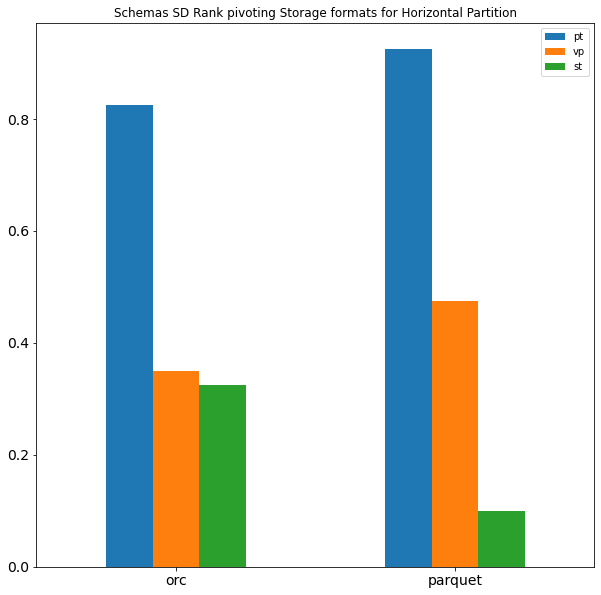

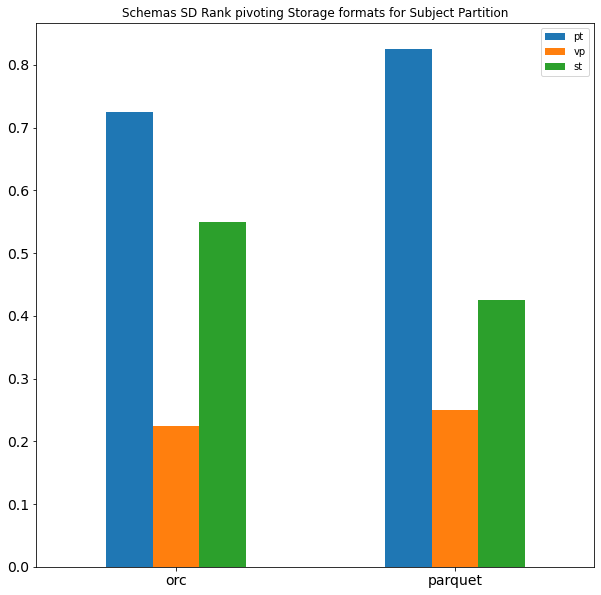

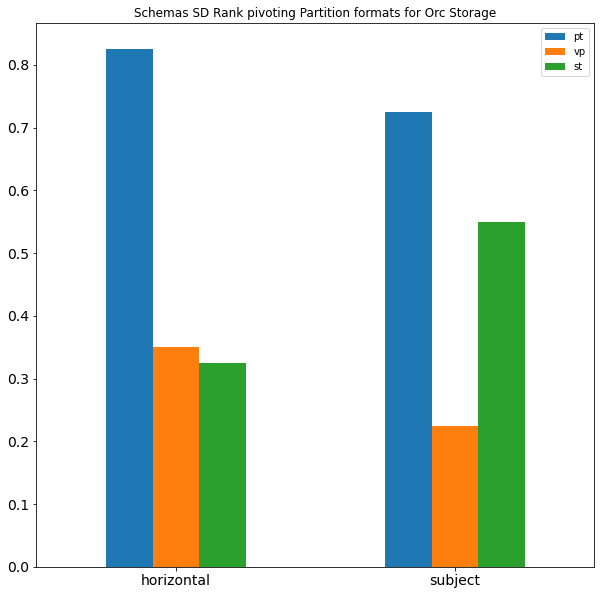

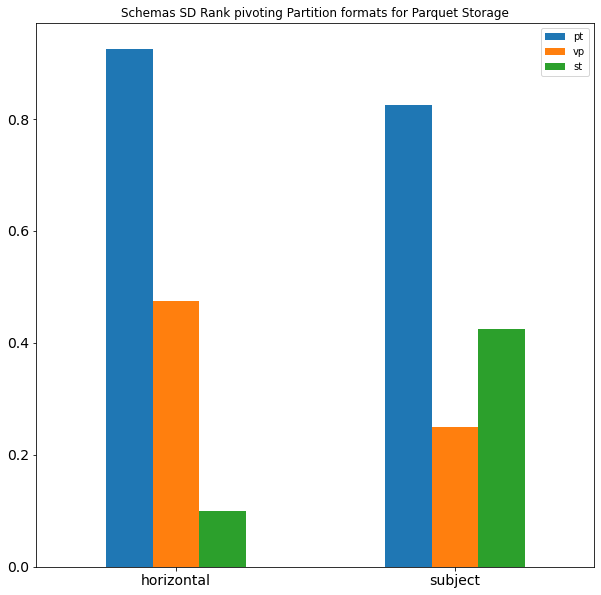

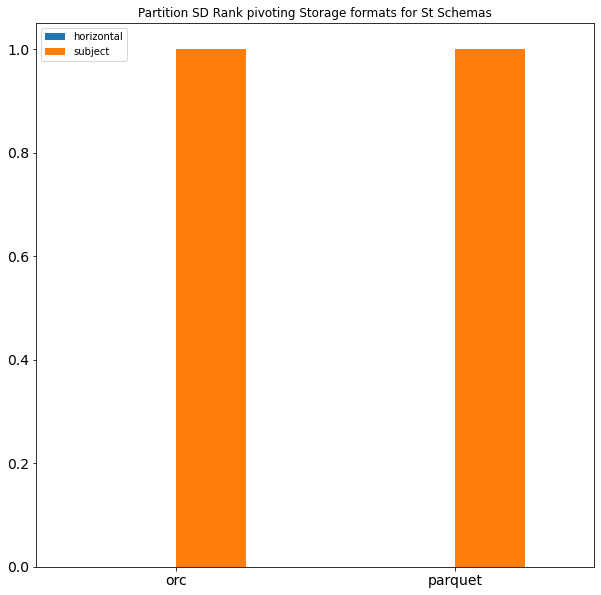

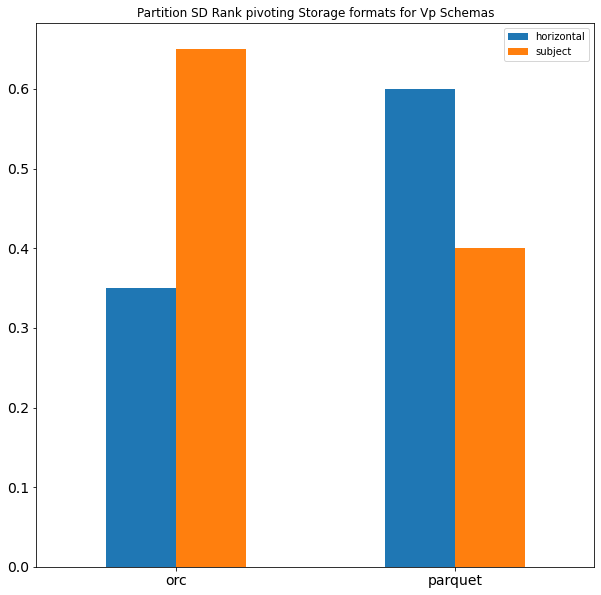

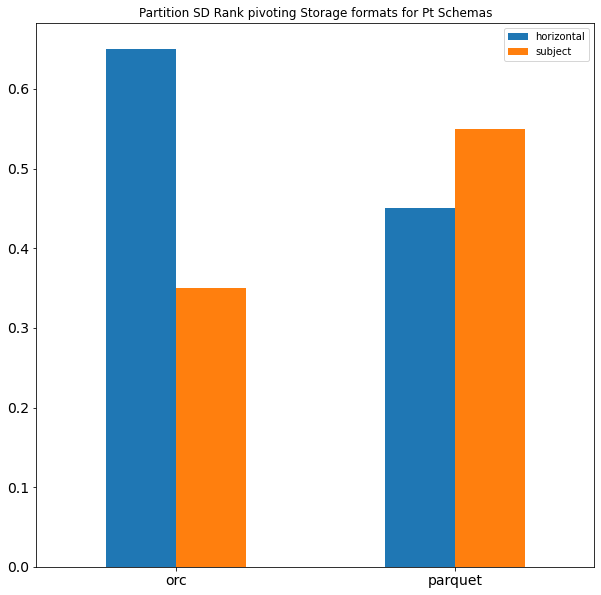

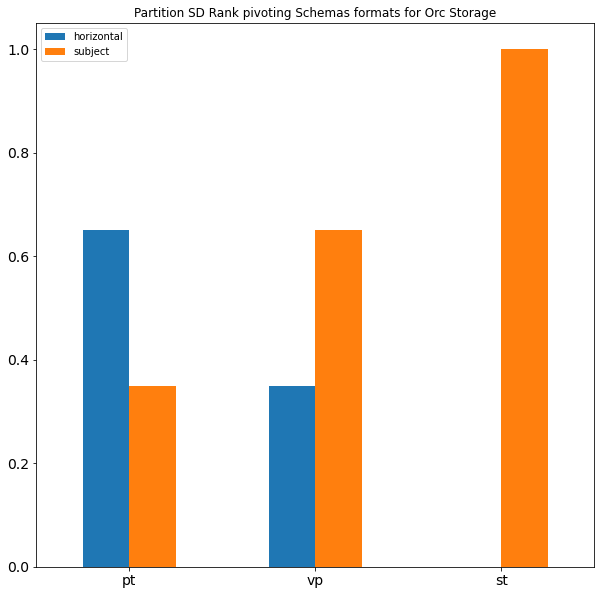

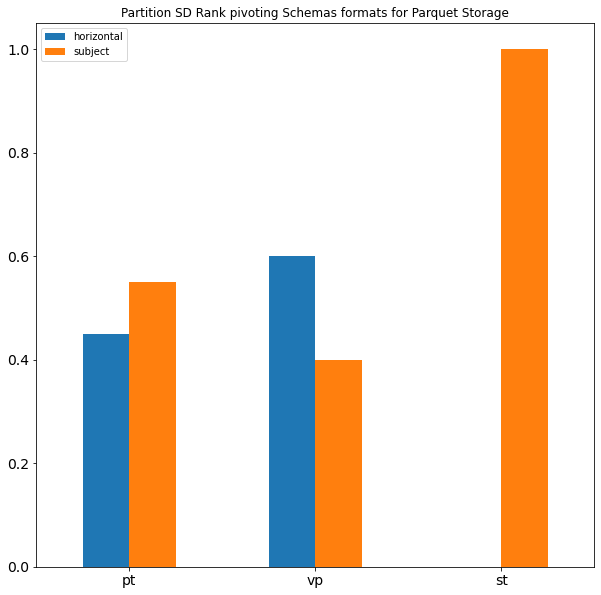

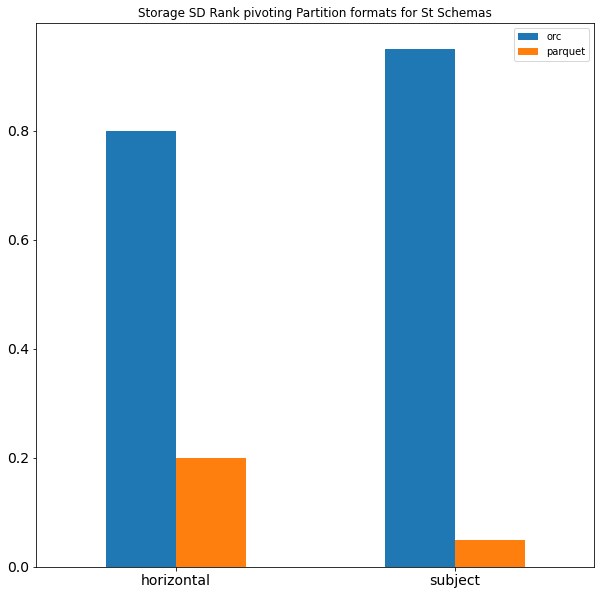

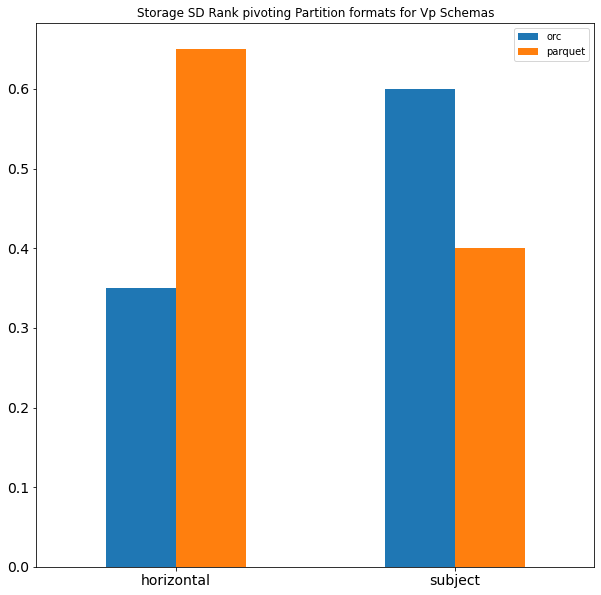

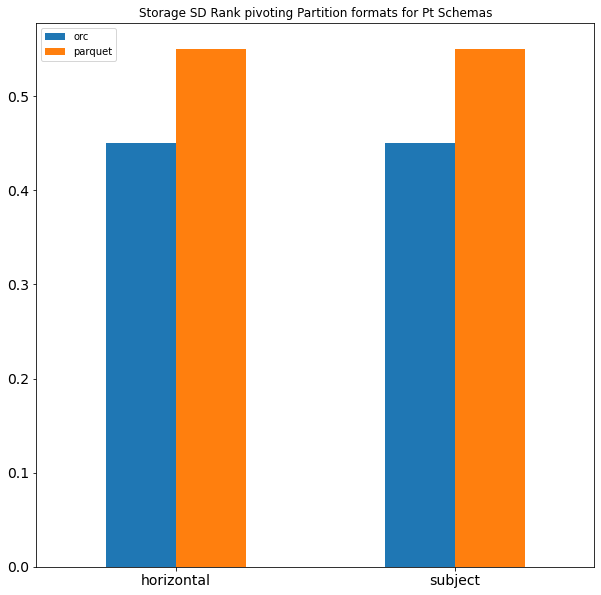

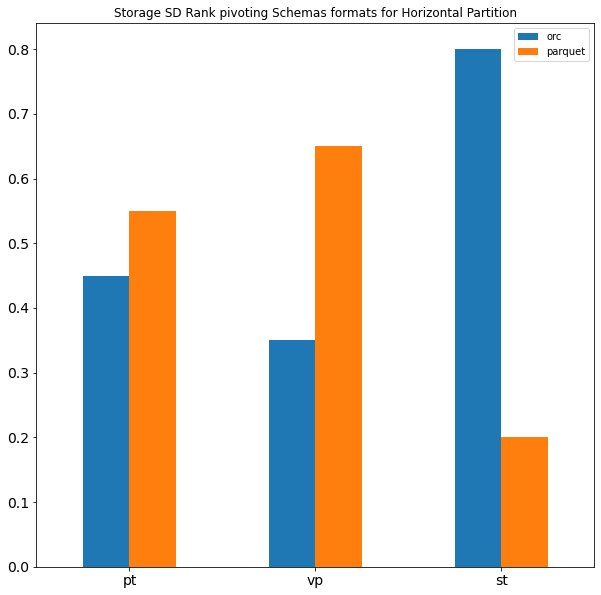

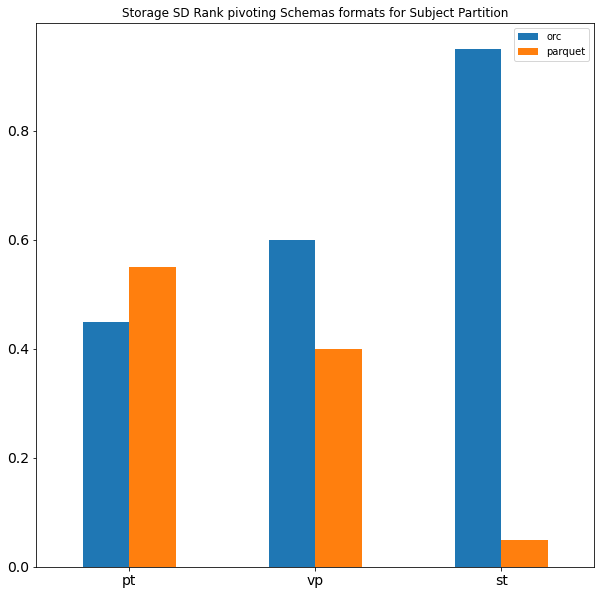

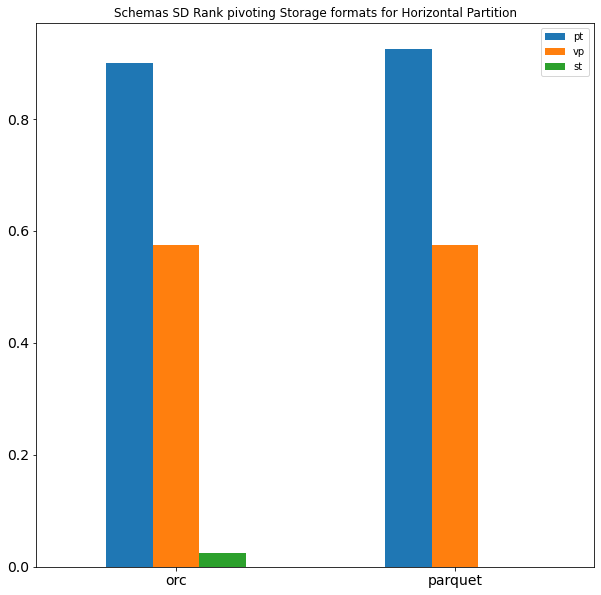

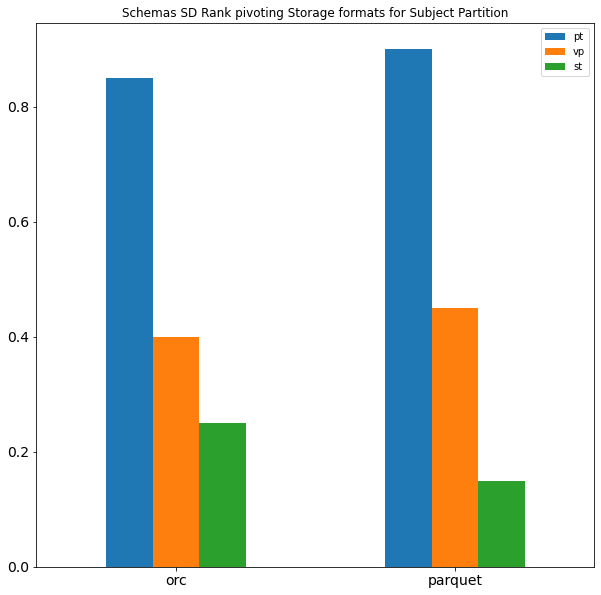

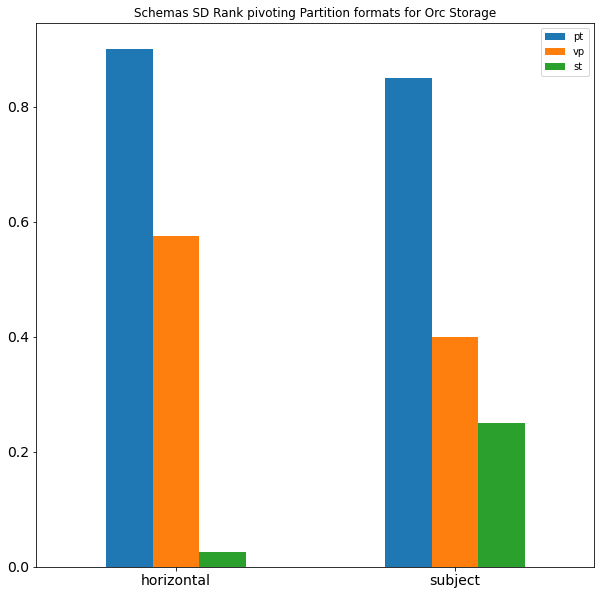

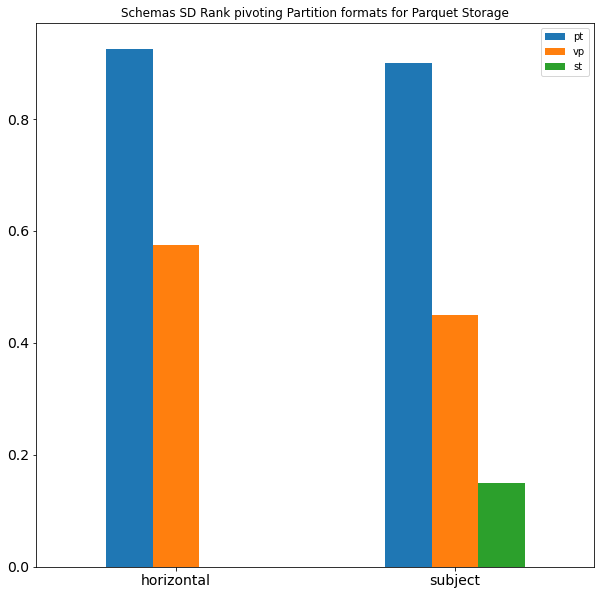

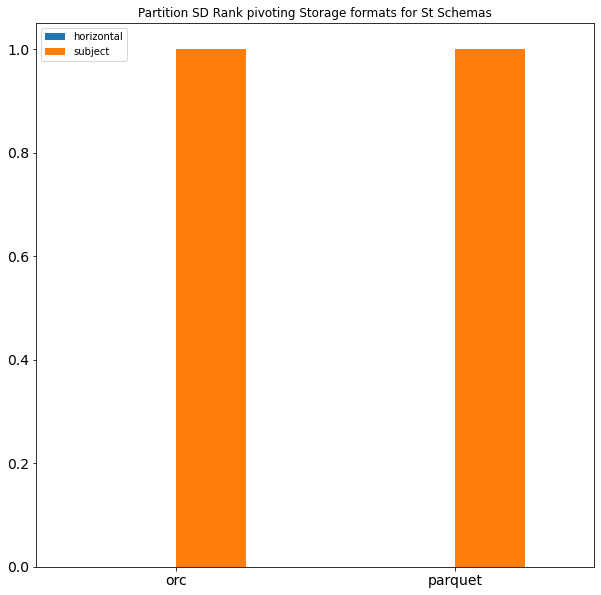

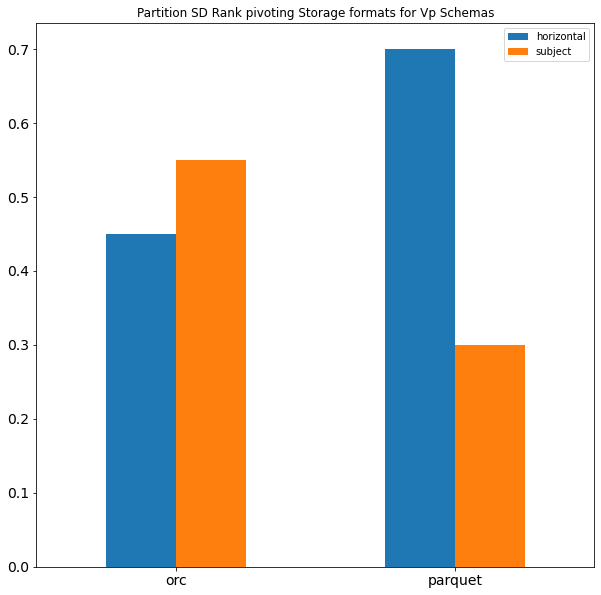

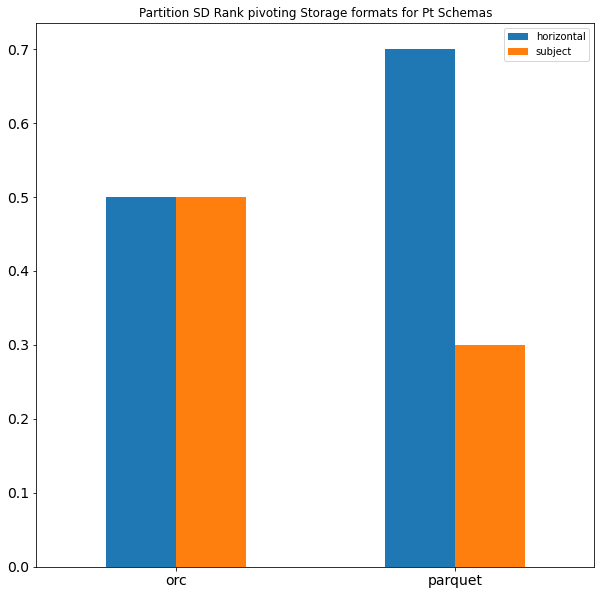

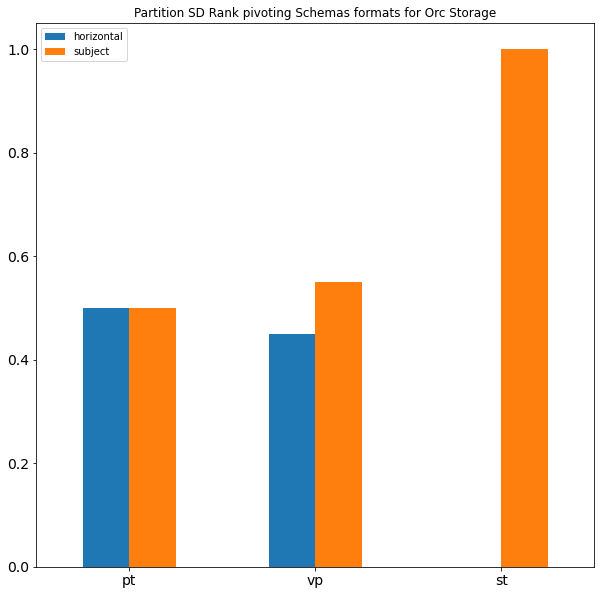

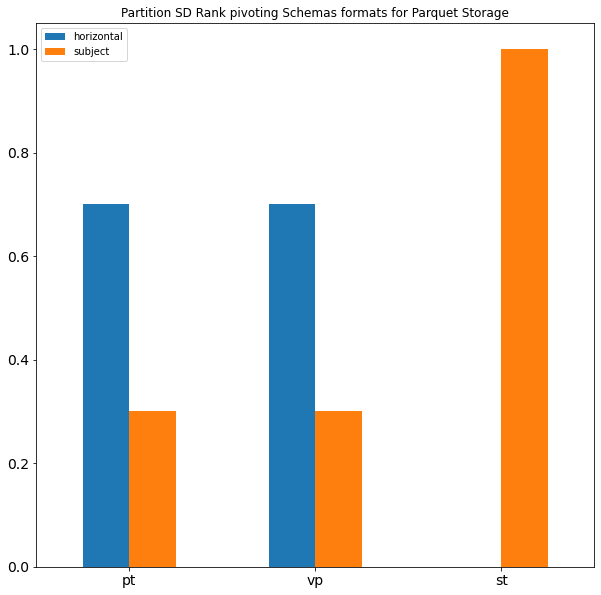

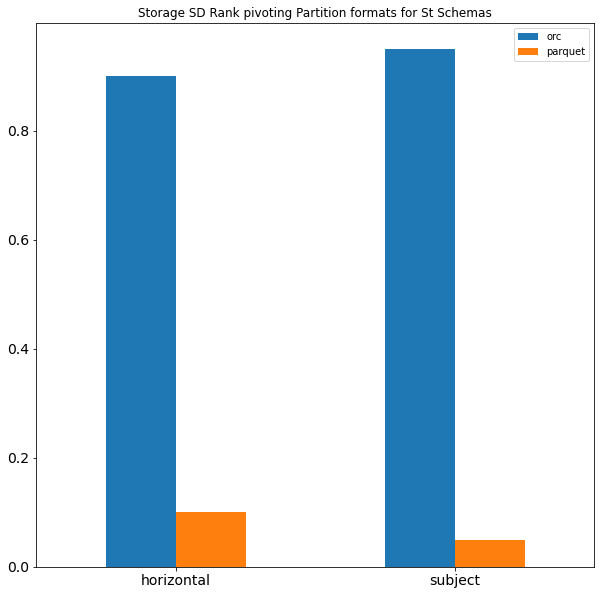

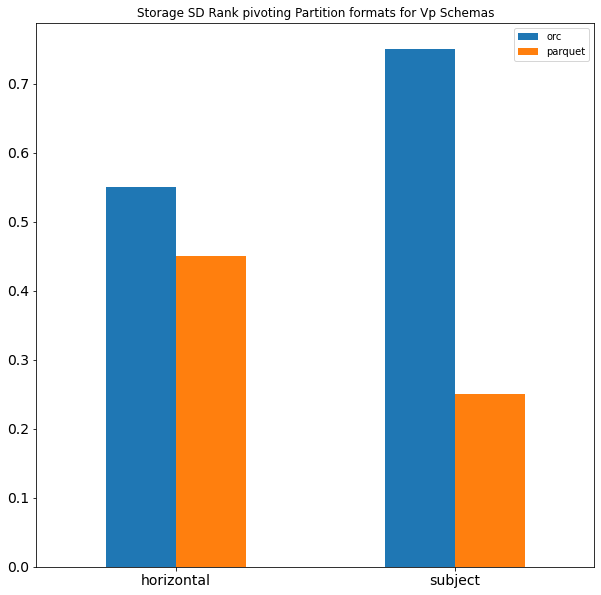

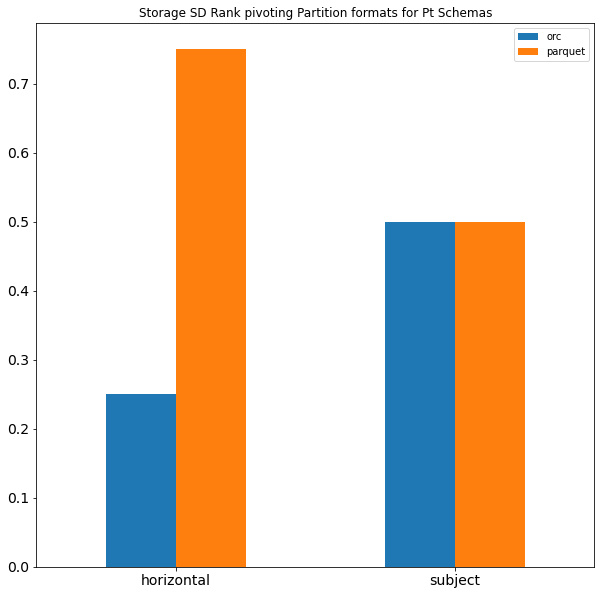

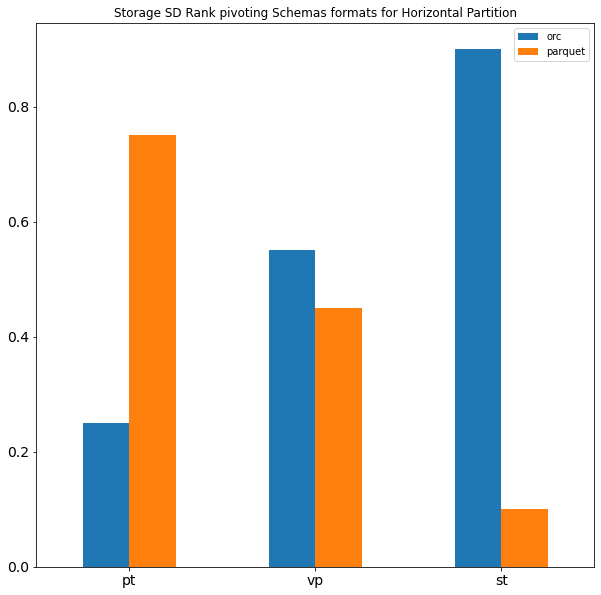

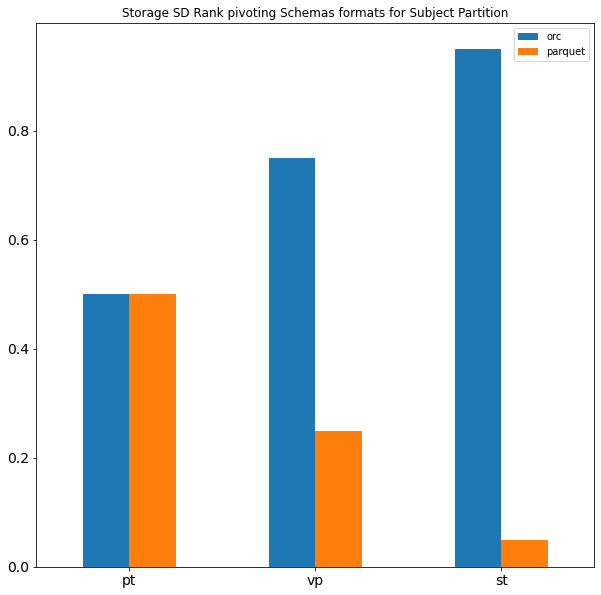

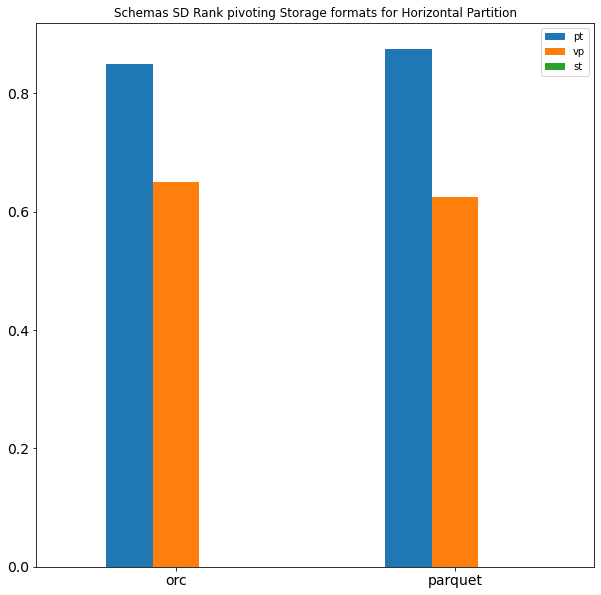

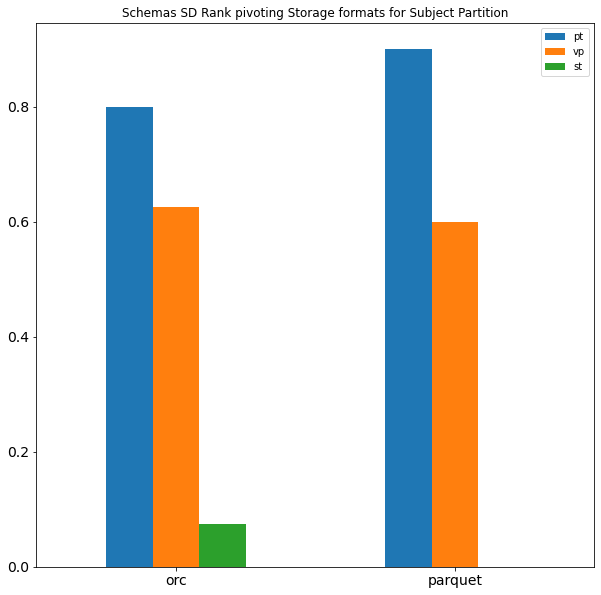

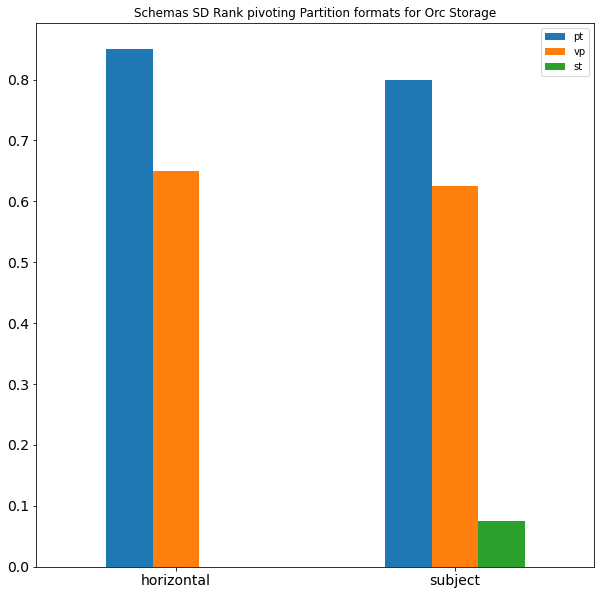

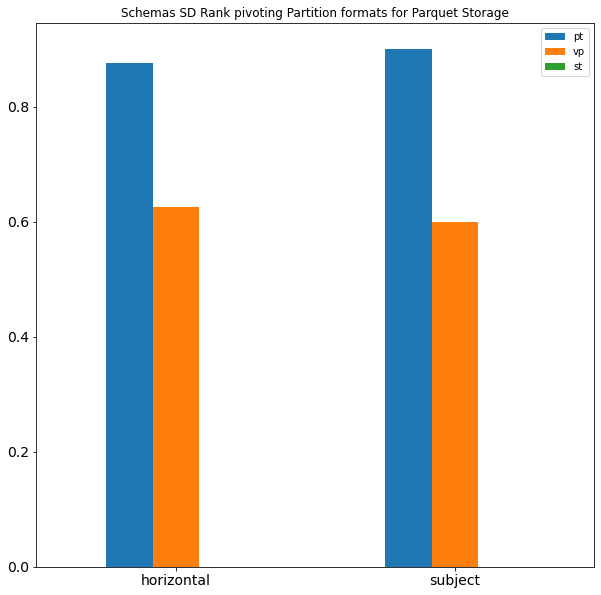

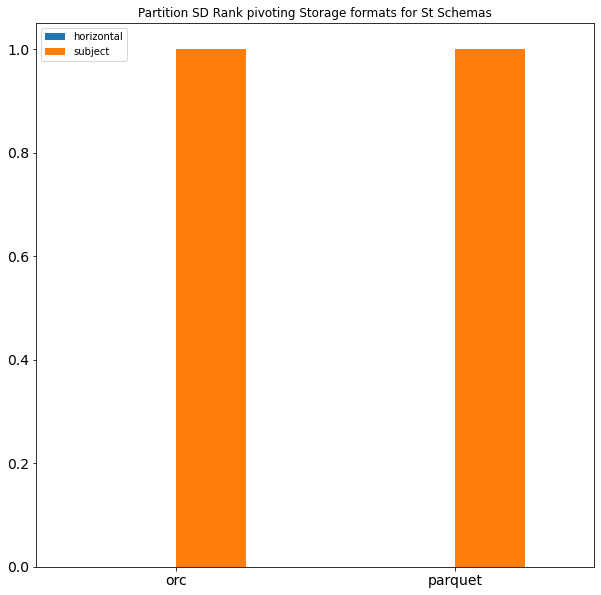

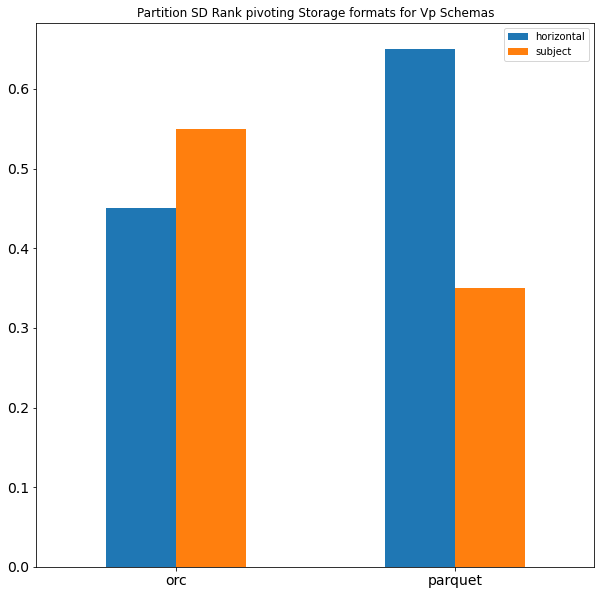

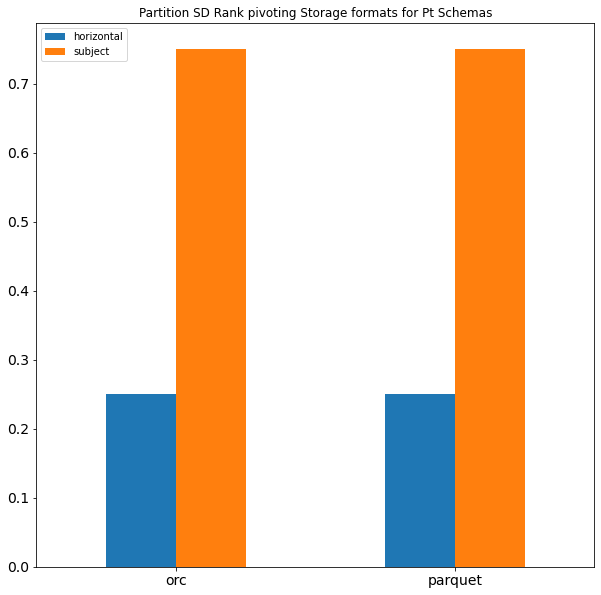

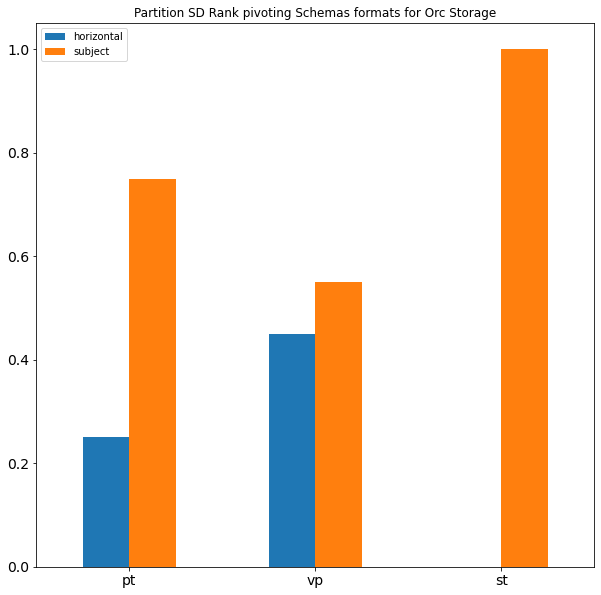

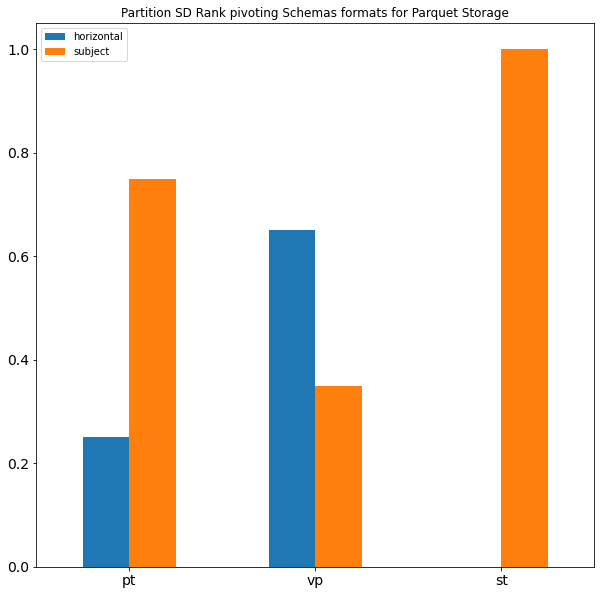

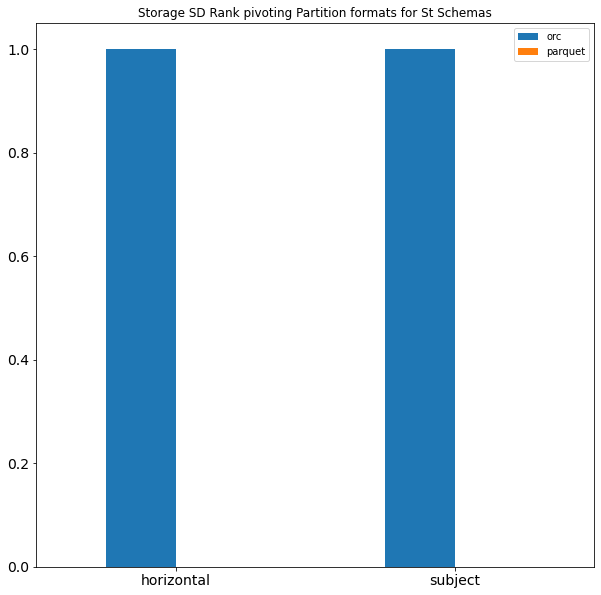

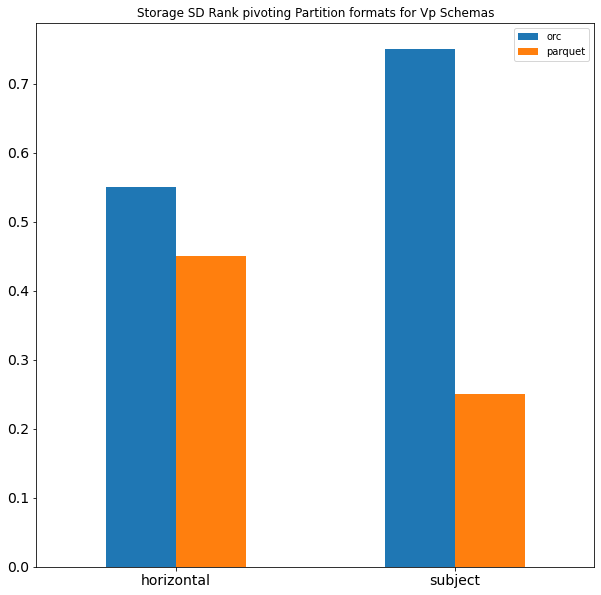

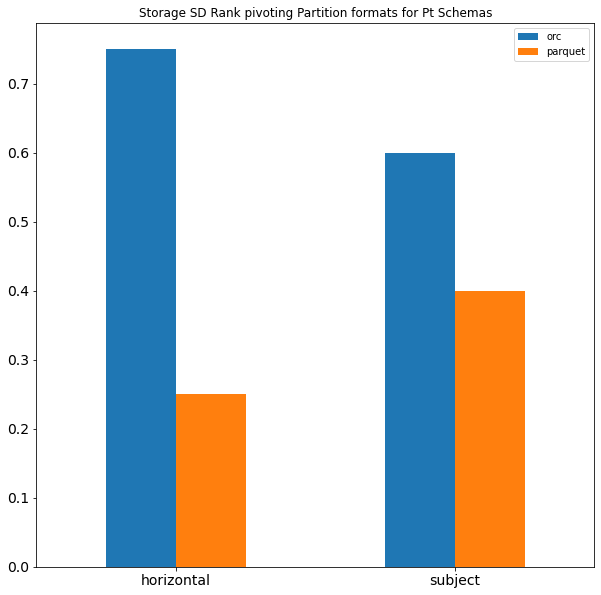

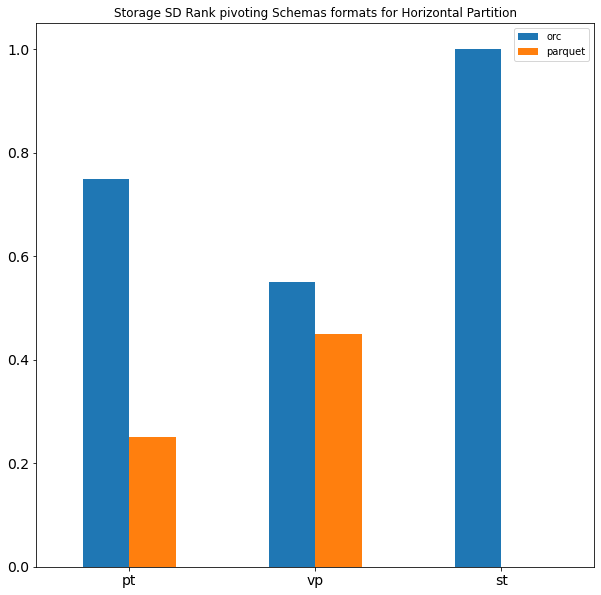

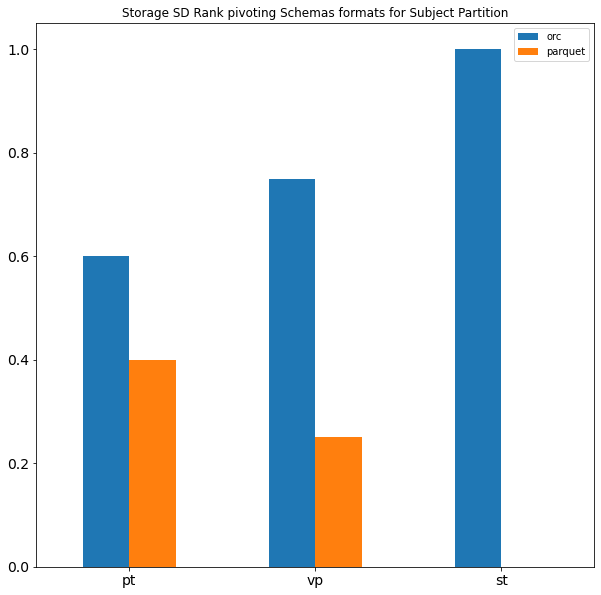

In [14]:
from Rank import SDRank

# example of schema dimension plots
SDRank(config_watdiv, logs_watdiv, '100M', 'schemas').plot('horizontal')
SDRank(config_watdiv, logs_watdiv, '100M', 'schemas').plot('predicate')
SDRank(config_watdiv, logs_watdiv, '100M', 'schemas').plot('subject')
SDRank(config_watdiv, logs_watdiv, '100M', 'schemas').plot('orc')
SDRank(config_watdiv, logs_watdiv, '100M', 'schemas').plot('avro')
SDRank(config_watdiv, logs_watdiv, '100M', 'schemas').plot('csv')
SDRank(config_watdiv, logs_watdiv, '100M', 'schemas').plot('parquet')
SDRank(config_watdiv, logs_watdiv, '100M', 'partition').plot('st')
SDRank(config_watdiv, logs_watdiv, '100M', 'partition').plot('vp')
SDRank(config_watdiv, logs_watdiv, '100M', 'partition').plot('pt')
SDRank(config_watdiv, logs_watdiv, '100M', 'partition').plot('extvp')
SDRank(config_watdiv, logs_watdiv, '100M', 'partition').plot('wpt')
SDRank(config_watdiv, logs_watdiv, '100M', 'partition').plot('orc')
SDRank(config_watdiv, logs_watdiv, '100M', 'partition').plot('avro')
SDRank(config_watdiv, logs_watdiv, '100M', 'partition').plot('csv')
SDRank(config_watdiv, logs_watdiv, '100M', 'partition').plot('parquet')
SDRank(config_watdiv, logs_watdiv, '100M', 'storage').plot('st')
SDRank(config_watdiv, logs_watdiv, '100M', 'storage').plot('vp')
SDRank(config_watdiv, logs_watdiv, '100M', 'storage').plot('pt')
SDRank(config_watdiv, logs_watdiv, '100M', 'storage').plot('extvp')
SDRank(config_watdiv, logs_watdiv, '100M', 'storage').plot('wpt')
SDRank(config_watdiv, logs_watdiv, '100M', 'storage').plot('horizontal')
SDRank(config_watdiv, logs_watdiv, '100M', 'storage').plot('predicate')
SDRank(config_watdiv, logs_watdiv, '100M', 'storage').plot('subject')
SDRank(config_watdiv, logs_watdiv, '250M', 'schemas').plot('horizontal')
SDRank(config_watdiv, logs_watdiv, '250M', 'schemas').plot('predicate')
SDRank(config_watdiv, logs_watdiv, '250M', 'schemas').plot('subject')
SDRank(config_watdiv, logs_watdiv, '250M', 'schemas').plot('orc')
SDRank(config_watdiv, logs_watdiv, '250M', 'schemas').plot('avro')
SDRank(config_watdiv, logs_watdiv, '250M', 'schemas').plot('csv')
SDRank(config_watdiv, logs_watdiv, '250M', 'schemas').plot('parquet')
SDRank(config_watdiv, logs_watdiv, '250M', 'partition').plot('st')
SDRank(config_watdiv, logs_watdiv, '250M', 'partition').plot('vp')
SDRank(config_watdiv, logs_watdiv, '250M', 'partition').plot('pt')
SDRank(config_watdiv, logs_watdiv, '250M', 'partition').plot('extvp')
SDRank(config_watdiv, logs_watdiv, '250M', 'partition').plot('wpt')
SDRank(config_watdiv, logs_watdiv, '250M', 'partition').plot('orc')
SDRank(config_watdiv, logs_watdiv, '250M', 'partition').plot('avro')
SDRank(config_watdiv, logs_watdiv, '250M', 'partition').plot('csv')
SDRank(config_watdiv, logs_watdiv, '250M', 'partition').plot('parquet')
SDRank(config_watdiv, logs_watdiv, '250M', 'storage').plot('st')
SDRank(config_watdiv, logs_watdiv, '250M', 'storage').plot('vp')
SDRank(config_watdiv, logs_watdiv, '250M', 'storage').plot('pt')
SDRank(config_watdiv, logs_watdiv, '250M', 'storage').plot('extvp')
SDRank(config_watdiv, logs_watdiv, '250M', 'storage').plot('wpt')
SDRank(config_watdiv, logs_watdiv, '250M', 'storage').plot('horizontal')
SDRank(config_watdiv, logs_watdiv, '250M', 'storage').plot('predicate')
SDRank(config_watdiv, logs_watdiv, '250M', 'storage').plot('subject')
SDRank(config_watdiv, logs_watdiv, '500M', 'schemas').plot('horizontal')
SDRank(config_watdiv, logs_watdiv, '500M', 'schemas').plot('predicate')
SDRank(config_watdiv, logs_watdiv, '500M', 'schemas').plot('subject')
SDRank(config_watdiv, logs_watdiv, '500M', 'schemas').plot('orc')
SDRank(config_watdiv, logs_watdiv, '500M', 'schemas').plot('avro')
SDRank(config_watdiv, logs_watdiv, '500M', 'schemas').plot('csv')
SDRank(config_watdiv, logs_watdiv, '500M', 'schemas').plot('parquet')
SDRank(config_watdiv, logs_watdiv, '500M', 'partition').plot('st')
SDRank(config_watdiv, logs_watdiv, '500M', 'partition').plot('vp')
SDRank(config_watdiv, logs_watdiv, '500M', 'partition').plot('pt')
SDRank(config_watdiv, logs_watdiv, '500M', 'partition').plot('extvp')
SDRank(config_watdiv, logs_watdiv, '500M', 'partition').plot('wpt')
SDRank(config_watdiv, logs_watdiv, '500M', 'partition').plot('orc')
SDRank(config_watdiv, logs_watdiv, '500M', 'partition').plot('avro')
SDRank(config_watdiv, logs_watdiv, '500M', 'partition').plot('csv')
SDRank(config_watdiv, logs_watdiv, '500M', 'partition').plot('parquet')
SDRank(config_watdiv, logs_watdiv, '500M', 'storage').plot('st')
SDRank(config_watdiv, logs_watdiv, '500M', 'storage').plot('vp')
SDRank(config_watdiv, logs_watdiv, '500M', 'storage').plot('pt')
SDRank(config_watdiv, logs_watdiv, '500M', 'storage').plot('extvp')
SDRank(config_watdiv, logs_watdiv, '500M', 'storage').plot('wpt')
SDRank(config_watdiv, logs_watdiv, '500M', 'storage').plot('horizontal')
SDRank(config_watdiv, logs_watdiv, '500M', 'storage').plot('predicate')
SDRank(config_watdiv, logs_watdiv, '500M', 'storage').plot('subject')

### Rank.SDRank.plotBox

#### SDRank.<b>plotBox</b>(<i>q = None</i>)
<small>In order to show the distributions of our query runtimes data, we need a box plot diagram to compare these data between queries in our experiment. Box plot can help provide information at a glance, giving us general information about our data</small><br><br>
<small>This method returns a box plot diagram that shows both maximum and minimum runtimes of each individual queries for a particular single dimensional ranking</small><br><br>
<i>Parameters:</i> <br>
&emsp; <b>q : list</b><br>
&emsp;&emsp;<small>This method can take a list of column names that user can specify to choose for plotting to have a more precise box plot diagram. i.e. list of ["Q1", "Q2", "Q3"] will output a <br>
&emsp;&emsp;&ensp;box plot only for those queries </small>

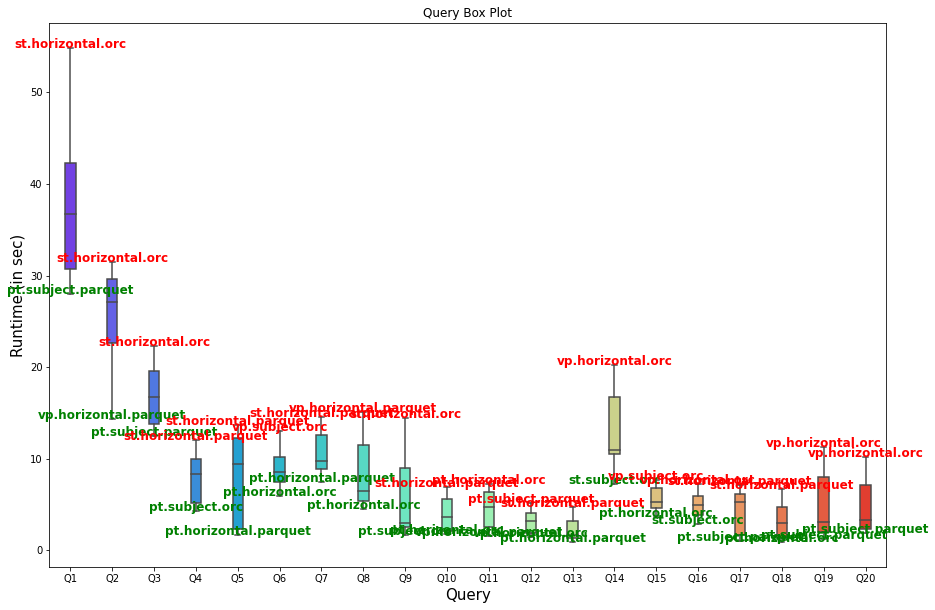

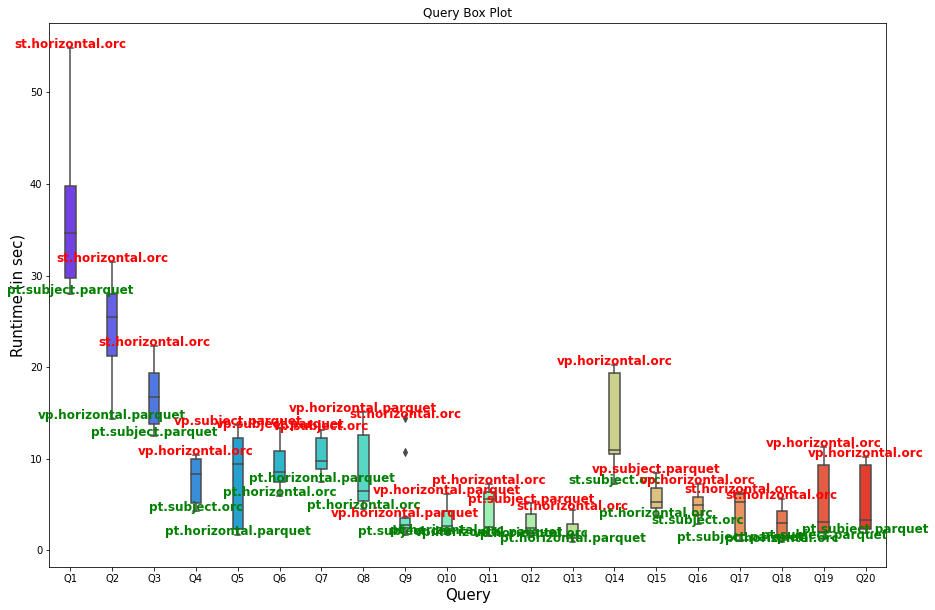

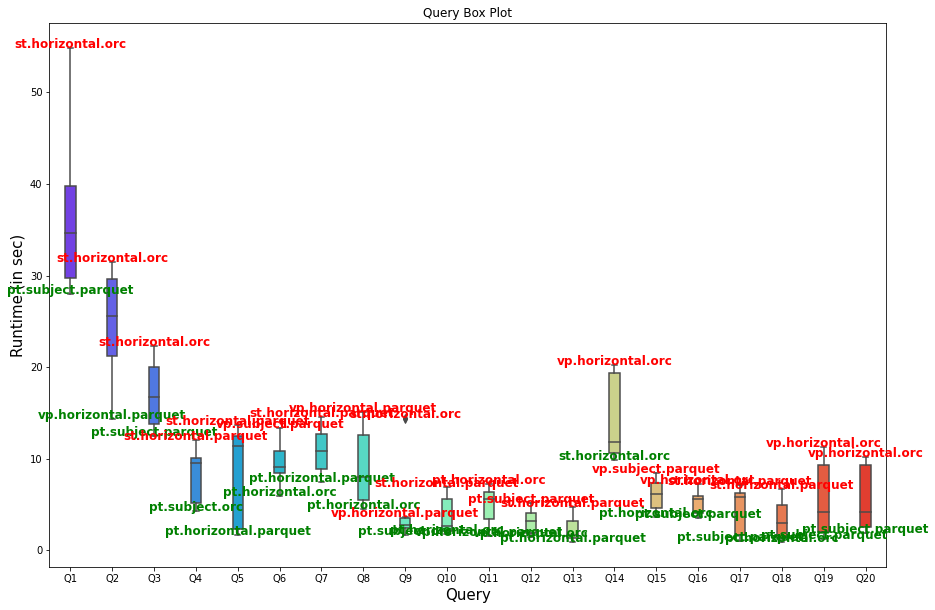

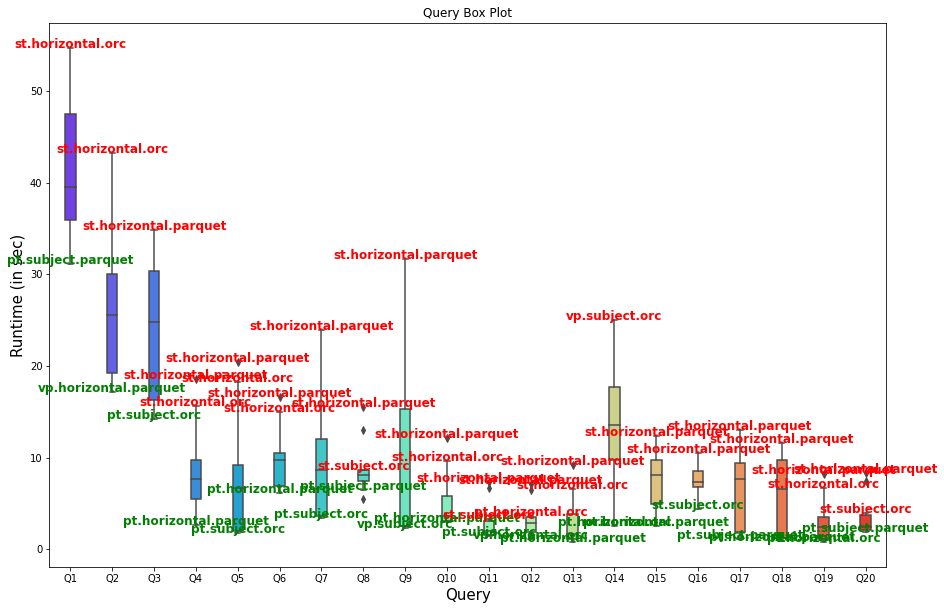

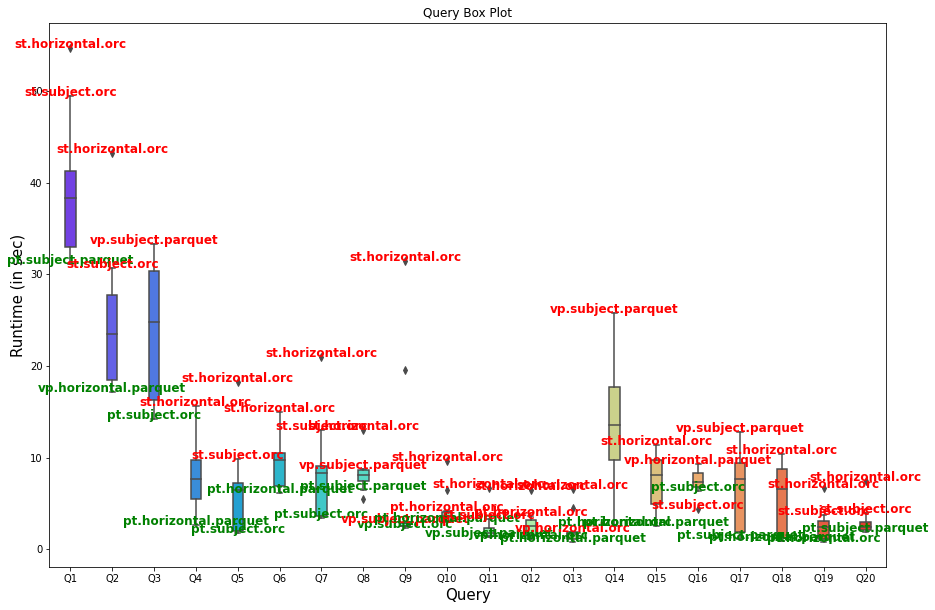

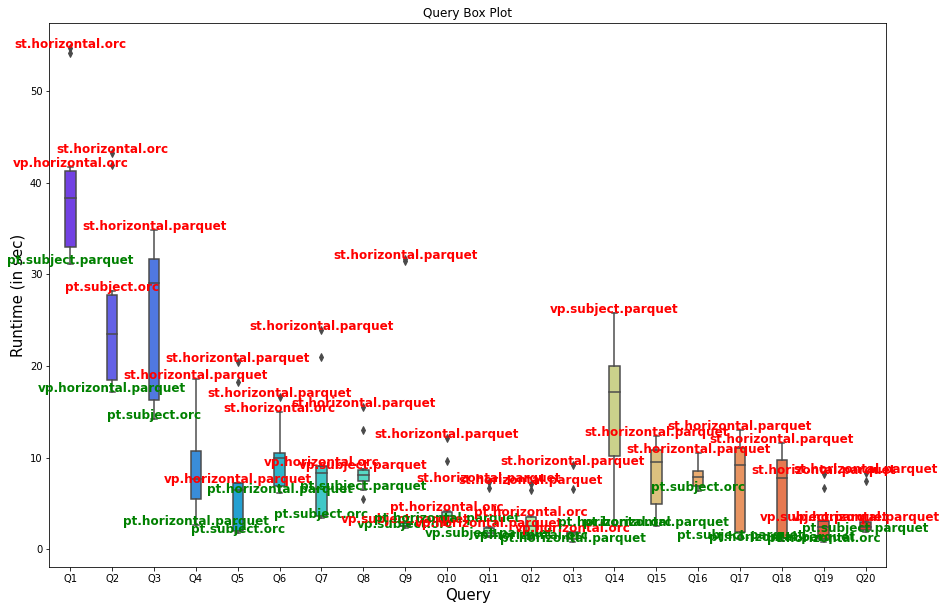

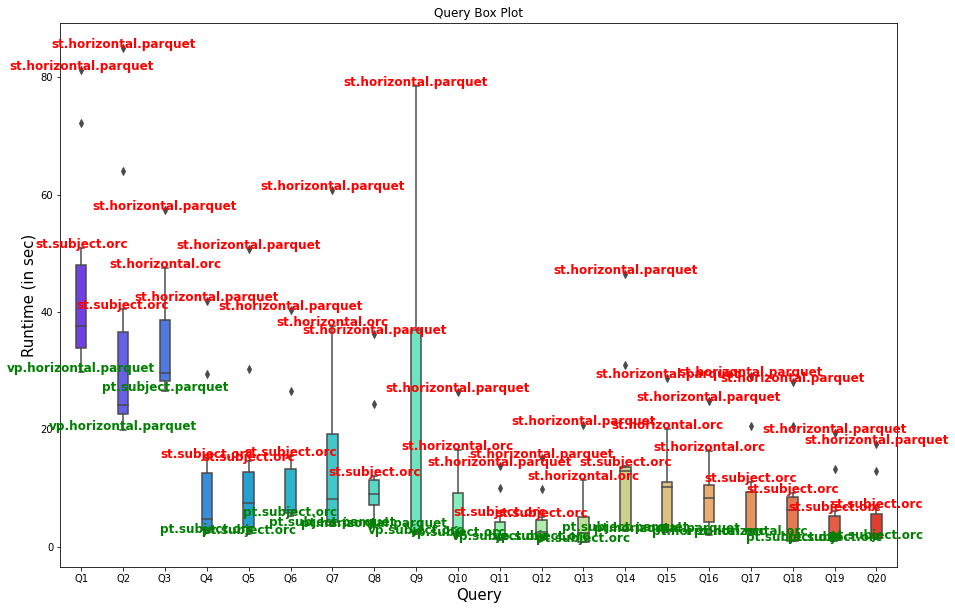

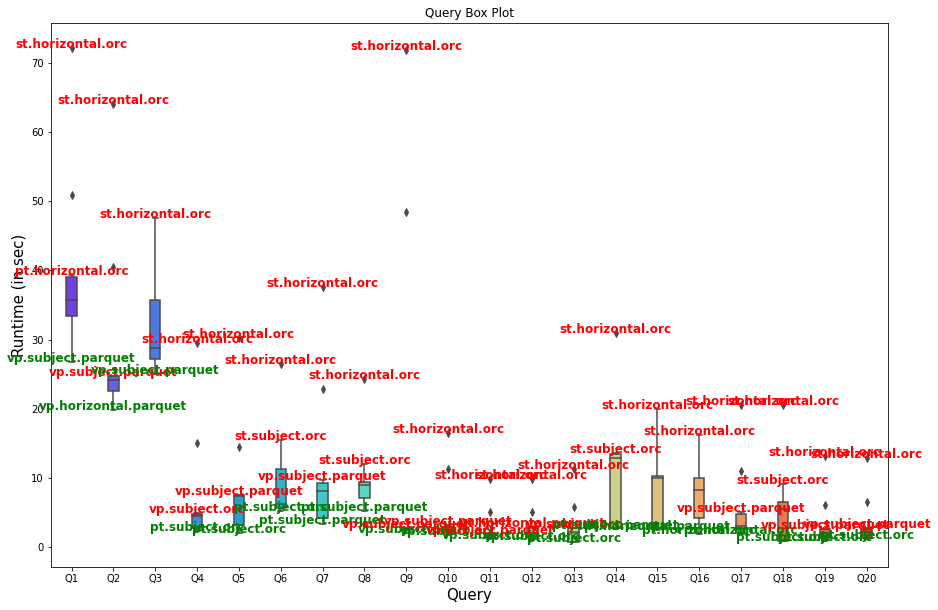

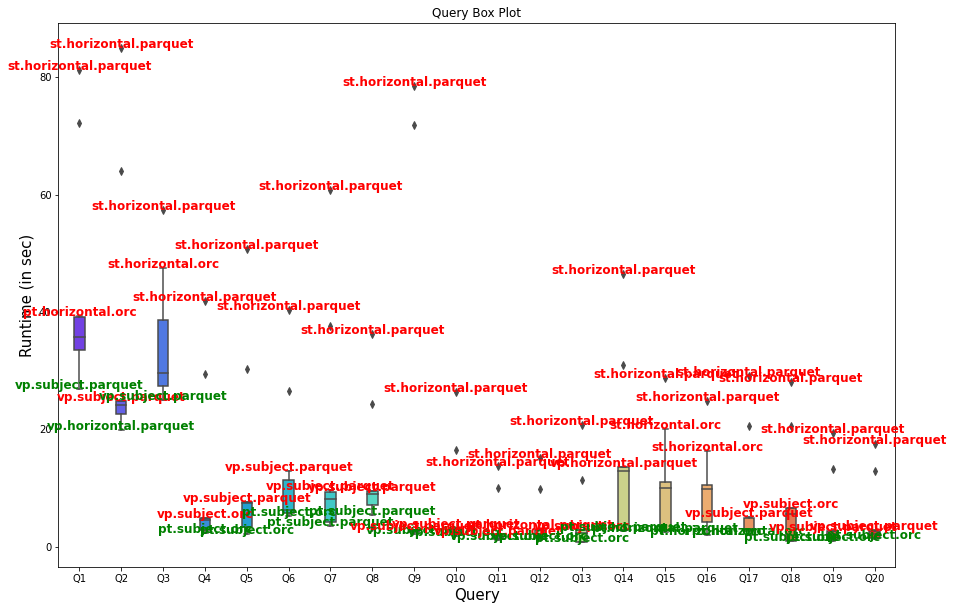

In [15]:
from Rank import SDRank

# Box plot example of all queries of schema ranking dimension
SDRank(config_watdiv, logs_watdiv, '100M', 'schemas').plotBox()
SDRank(config_watdiv, logs_watdiv, '100M', 'partition').plotBox()
SDRank(config_watdiv, logs_watdiv, '100M', 'storage').plotBox()
SDRank(config_watdiv, logs_watdiv, '250M', 'schemas').plotBox()
SDRank(config_watdiv, logs_watdiv, '250M', 'partition').plotBox()
SDRank(config_watdiv, logs_watdiv, '250M', 'storage').plotBox()
SDRank(config_watdiv, logs_watdiv, '500M', 'schemas').plotBox()
SDRank(config_watdiv, logs_watdiv, '500M', 'partition').plotBox()
SDRank(config_watdiv, logs_watdiv, '500M', 'storage').plotBox()

### Multi Dimensional Ranking

With the presence of the trade-offs introduced in the single dimensional ranking function, we propose an optimization technique that aims to find the non-dominated solutions or the configuration combinations by optimizing all dimensions at the same time which utilize the NSGA2 Algorithm.<br>
In this experiment, we provide two ways to use the NSGA2 Algorithm:
- The first method is _paretoAgg_ which operates on the single dimensional ranking criteria. This method aims to maximize performance of the three ranks altogether
- The second method is _paretoQ_ which apply the algorithm considering the rank sets obtained by sorting each query results individually. This method aims at minimizing query runtimes of the ranked dimensions

### PAPyA.Rank.MDRank

#### <i>class</i> Rank.<b>SDRank</b>(<i>config_path, log_path, ranking_sets</i>)
<i>Parameters:</i> <br>
&emsp; <b>config_path : str</b><br>
&emsp;&emsp;<small>Specify the path to your configuration file(s). <i>i.e ./UIModule/settings_watdiv.yaml</small></i><br>
&emsp;<b>log_path : str</b><br>
&emsp;&emsp;<small>Specify the path to your log file(s). <i>i.e ./UI Module/log_watdiv</small></i><br>
&emsp;<b>ranking_sets : str</b><br>
&emsp;&emsp;<small>Ranking sets of user choice. <i>i.e dataset sizes (100M)</small></i><br>

In [20]:
from Rank import MDRank

# example of MDRank class with 100M dataset size as ranking set of the experiment
multiDimensionRank_100M = MDRank(config_watdiv, logs_watdiv, '100M')
multiDimensionRank_250M = MDRank(config_watdiv, logs_watdiv, '250M')
multiDimensionRank_500M = MDRank(config_watdiv, logs_watdiv, '500M')

### Rank.MDRank.paretoQ

#### MDRank.<b>paretoQ</b>()
<small>This method returns a table of configuration solutions as well as their dominated ones, according to the Non-Dominated Sorting Algorithm II (NSGA2) that was applied to minimizing query runtimes of the ranked dimensions</small>

In [21]:
multiDimensionRank_100M.paretoQ()

,Solution,Dominated
0,pt.subject.csv,st.horizontal.orc
1,vp.subject.csv,st.horizontal.parquet
2,pt.horizontal.csv,st.subject.csv
3,vp.horizontal.csv,st.horizontal.csv
4,pt.horizontal.parquet,
5,pt.subject.parquet,
6,pt.horizontal.orc,
7,pt.subject.orc,
8,st.subject.orc,
9,vp.horizontal.parquet,


In [22]:
multiDimensionRank_250M.paretoQ()

,Solution,Dominated
0,pt.horizontal.parquet,st.subject.parquet
1,pt.subject.csv,st.horizontal.orc
2,pt.horizontal.csv,st.horizontal.parquet
3,pt.horizontal.orc,st.subject.csv
4,pt.subject.parquet,st.horizontal.csv
5,pt.subject.orc,
6,vp.subject.csv,
7,vp.horizontal.csv,
8,vp.horizontal.orc,
9,vp.subject.orc,


In [23]:
multiDimensionRank_500M.paretoQ()

,Solution,Dominated
0,pt.subject.orc,st.horizontal.orc
1,pt.subject.parquet,st.subject.parquet
2,pt.horizontal.orc,st.horizontal.parquet
3,pt.horizontal.parquet,st.subject.csv
4,pt.subject.csv,st.horizontal.csv
5,vp.subject.csv,
6,vp.subject.orc,
7,vp.horizontal.orc,
8,vp.horizontal.parquet,
9,pt.horizontal.csv,


### Rank.MDRank.paretoAgg

#### MDRank.<b>paretoAgg</b>()
<small>This method returns a table of configuration solutions as well as their dominated ones, according to the Non-Dominated Sorting Algorithm II (NSGA2) that was applied on the single dimensional ranking criteria which maximizes the performance of all ranking sets altogether</small>

In [24]:
multiDimensionRank_100M.paretoAgg()

,Solution,Dominated
0,st.subject.orc,st.subject.parquet
1,pt.subject.csv,vp.horizontal.csv
2,vp.subject.csv,pt.horizontal.csv
3,pt.horizontal.parquet,pt.subject.parquet
4,,pt.horizontal.orc
5,,vp.horizontal.parquet
6,,pt.subject.orc
7,,st.horizontal.orc
8,,vp.subject.orc
9,,vp.horizontal.orc


In [25]:
multiDimensionRank_250M.paretoAgg()

,Solution,Dominated
0,pt.horizontal.parquet,pt.subject.csv
1,vp.subject.csv,pt.subject.orc
2,st.subject.orc,pt.horizontal.orc
3,,pt.horizontal.csv
4,,st.subject.parquet
5,,pt.subject.parquet
6,,vp.horizontal.parquet
7,,vp.horizontal.csv
8,,vp.horizontal.orc
9,,vp.subject.orc


In [26]:
multiDimensionRank_500M.paretoAgg()

,Solution,Dominated
0,vp.subject.csv,vp.horizontal.parquet
1,pt.subject.orc,vp.subject.orc
2,pt.subject.parquet,pt.horizontal.parquet
3,st.subject.orc,vp.horizontal.orc
4,pt.subject.csv,st.subject.parquet
5,pt.horizontal.orc,vp.horizontal.csv
6,,vp.subject.parquet
7,,st.subject.csv
8,,st.horizontal.orc
9,,pt.horizontal.csv


### Rank.MDRank.plot

#### MDRank.<b>plot</b>()
<small>This method returns a plot for multi dimensional ranking solutions according to paretoAgg as shades of green projected in a three dimensional space</small>

(4, 3) (8, 3)


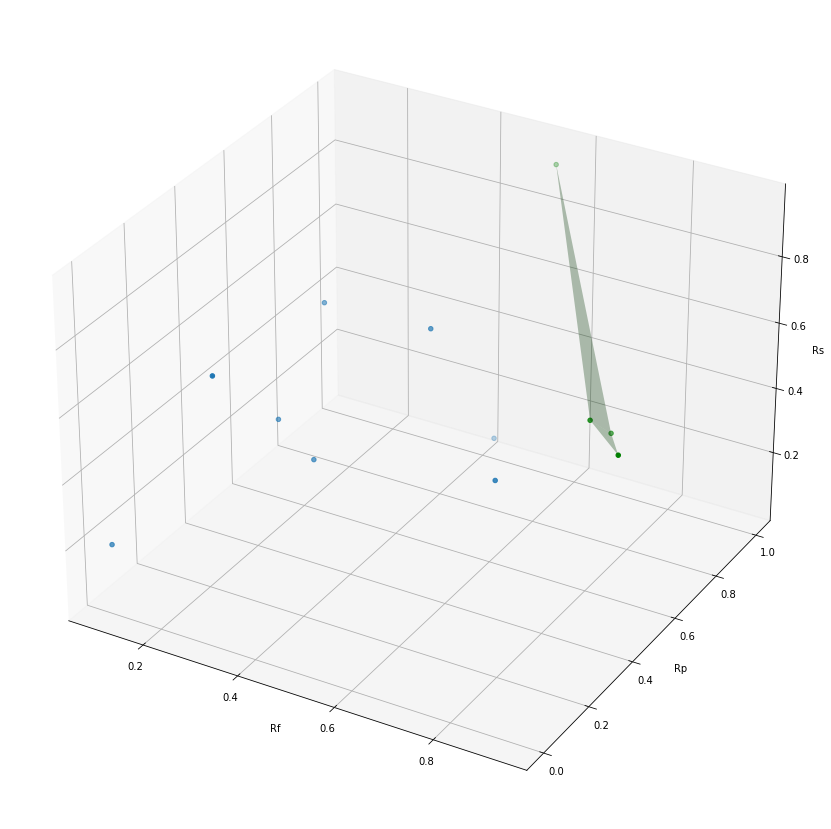

(5, 3) (7, 3)


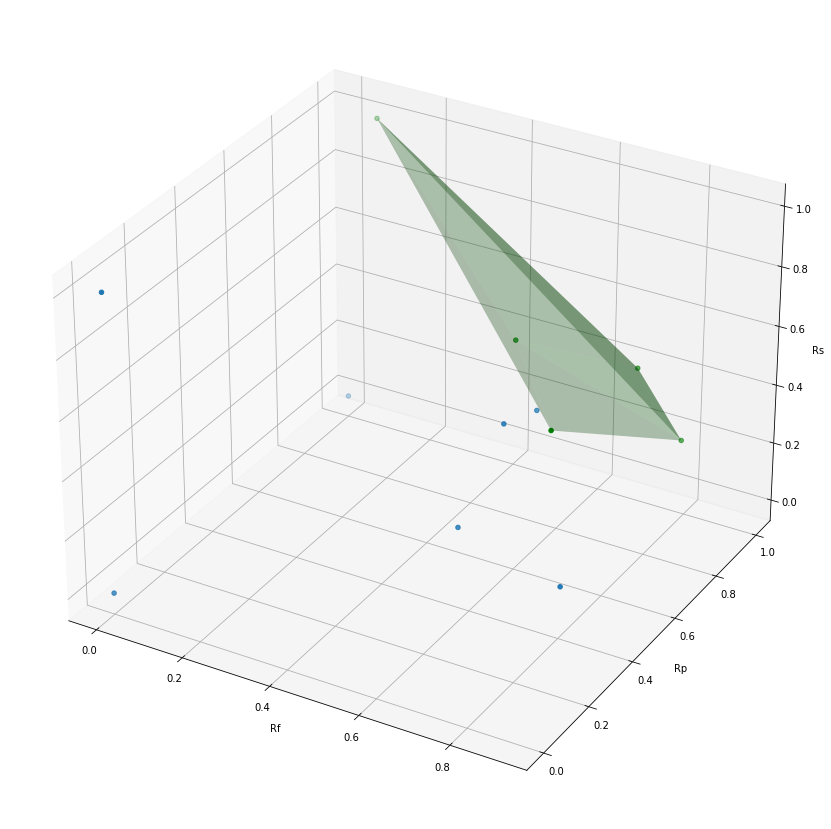

In [23]:
multiDimensionRank_100M.plot()
multiDimensionRank_500M.plot()

### Ranking Criteria Validation

This library provides two metrics of evaluation to evaluate the goodness of the ranking criteria the _conformance_ and _coherence_

- Conformance measures the adherence of the top-ranked configurations according to the actual query positioning of thoses configurations. We calculate conformance according to the equation below:

$$A(R^k) = 1 - \sum \limits _{i=0} ^{|Q|} \sum \limits _{j=0} ^{k} \frac {\bar{A}(i,j)}{|Q|*k}$$

Consider $R_{s}$ ranking and the top-3 ranked configurations are ${c_{1},c_{2},c_{3}}$, that overlaps only with the bottom-3 ranked configuration in query $|Q|$. That is, ${c_{4},c_{2},c_{5}}$. For example, $c_{2}$ is in the $59^{th}$ position out of 60 positions. <br>
Thus, $A(R^k) = 1- \frac {1}{(11*3)}$, when $k = 3$ and $|Q| = 11$

- Coherence is the measure agreement between two ranking sets that uses the same ranking criteria accross different experiments. We used Kendall's Index to calculate coherence, which counts the number of dis(agreements) between two ranking sets

$$K(R_{1}, R_{2}) = \sum \limits _{{i,j} \epsilon P} ^{} \frac {\bar{K}_{i,j}(R_{1}, R_{2})}{|P|}$$

In this experiment, we assume that rank sets are the dataset sizes (i.e. 100M and 250M). Kendall’s distance between two rank sets $R_{1}$ and $R_{2}$, where $|P|$ represents the set of unique pairs of distinct elements in the two sets. For instance, the $K$ index between $R_{1}={c_{1},c_{2},c_{3}}$ and $R_{2}={c_{1},c_{2},c_{4}}$ for 100M and 250M is 0.33, i.e., one disagreement out of three pair comparisons.

### PAPyA.Ranker.Conformance

#### <i>class</i> Ranker.<b>Conformance</b>(<i>config_path, log_path, ranking_sets, conformance_set, k, h</i>)
<i>Parameters:</i> <br>
&emsp; <b>config_path : str</b><br>
&emsp;&emsp;<small>Specify the path to your configuration file(s). <i>i.e ./UIModule/settings_watdiv.yaml</small></i><br>
&emsp;<b>log_path : str</b><br>
&emsp;&emsp;<small>Specify the path to your log file(s). <i>i.e ./UI Module/log_watdiv</small></i><br>
&emsp;<b>ranking_sets : str</b><br>
&emsp;&emsp;<small>Ranking sets of user choice. <i>i.e dataset sizes (100M)</small></i><br>
&emsp;<b>conformance_set : list</b><br>
&emsp;&emsp;<small>List of ranking criterions to see the scores of their conformances.</small><br>
&emsp;<b>k : int</b><br>
&emsp;&emsp;<small>Value of the top k subset of the ranking criteria. <i>i.e. _k_ = 5, takes the top 5 value of each ranking criteria in the conformance set</small></i><br>
&emsp;<b>h : int</b><br>
&emsp;&emsp;<small>Value of the threshold that will be counted for the conformance score. <i>i.e. _h_ = 28, take queries that has a ranking below 28 out of all the configuration</small></i><br>

In [2]:
from Ranker import Conformance
config_watdiv = 'settings_watdiv.yaml'
logs_watdiv = 'log_watdiv'

conformance_set = ['schemas','partition','storage','paretoQ','paretoAgg','RTA']
conf_100M = Conformance('settings_watdiv.yaml', 'log_watdiv', '100M', conformance_set, 5, 28)
conf_250M = Conformance(config_watdiv, logs_watdiv, '250M', conformance_set, 5, 28)
conf_500M = Conformance(config_watdiv, logs_watdiv, '500M', conformance_set, 5, 28)

### Ranker.Conformance.run

#### Conformance.<b>run</b>()
<small>This method returns a table of conformance scores for each of the ranking criterion that user specify in the conformance_set along with the k and h values for the formula</small>

In [5]:
#conformance scores for all ranking criterions in 250M dataset size
conf_100M.run()

,100M
schemas,0.883333
partition,0.383333
storage,0.633333
paretoQ,0.950000
paretoAgg,0.883333
RTA,0.883333


[0.95, 0.9, 1.0] [0.050000000000000044, 0.09999999999999998, 0.0]


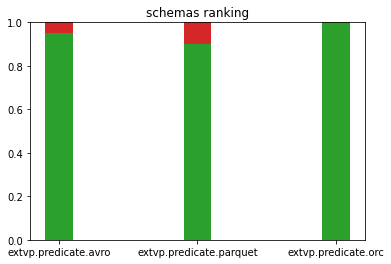

[0.9, 0.65, 0.85] [0.09999999999999998, 0.35, 0.15000000000000002]


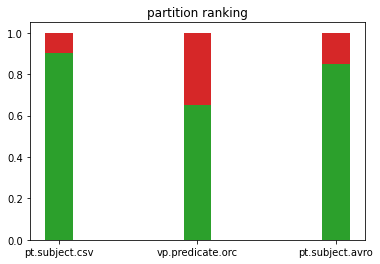

[0.6, 0.25, 0.95] [0.4, 0.75, 0.050000000000000044]


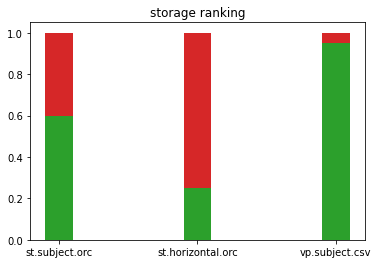

[1.0, 1.0, 0.9] [0.0, 0.0, 0.09999999999999998]


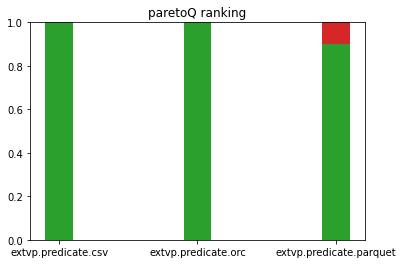

[0.9, 1.0, 0.95] [0.09999999999999998, 0.0, 0.050000000000000044]


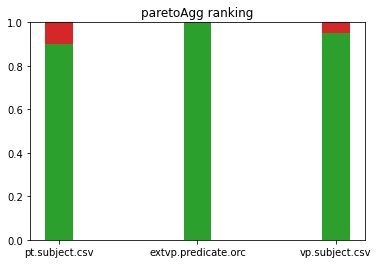

[0.9, 1.0, 0.95] [0.09999999999999998, 0.0, 0.050000000000000044]


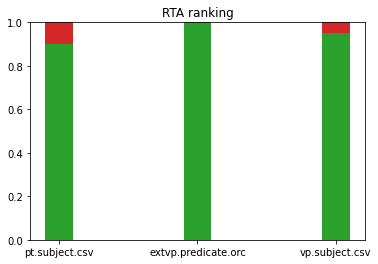

In [2]:
conf_100M.plot(1)

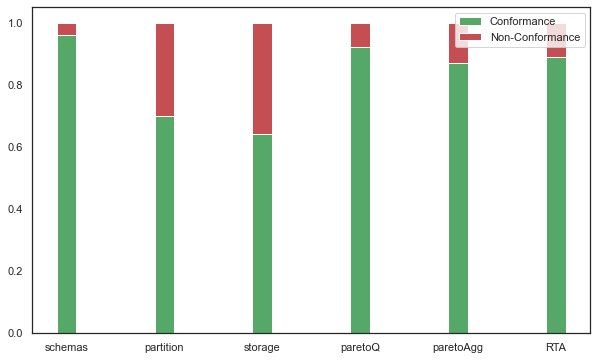

In [3]:
conf_100M.plot()

In [7]:
conf_250M.run()

,250M
schemas,0.916667
partition,0.133333
storage,0.466667
paretoQ,0.983333
paretoAgg,0.733333
RTA,0.733333


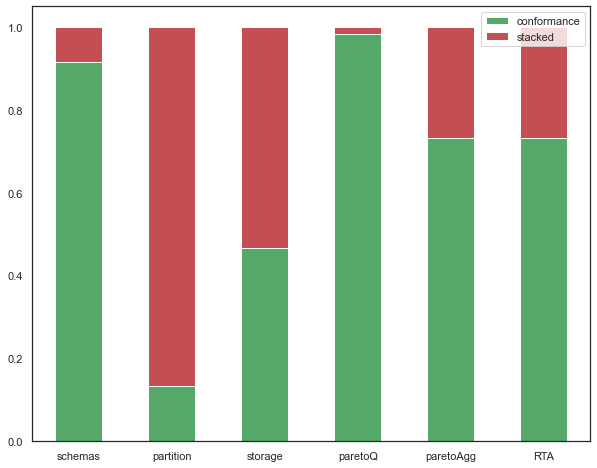

In [8]:
conf_250M.plot()

In [34]:
conf_500M.run()

,500M
schemas,0.933333
partition,0.050000
storage,0.350000
paretoQ,0.950000
paretoAgg,0.933333
RTA,0.933333


### Ranker.Conformance.configurationQueryRanks

#### Conformance.<b>configurationQueryRanks</b>(<i>dimension, mode</i>)
<small>This method returns a criteria table of a choosen ranking dimension, criteria table is a table that shows rank values of each queries by the top-k configurations</small><br><br>
<i>Parameters:</i> <br>
&emsp; <b>dimension : str</b><br>
&emsp;&emsp;<small>user's choosen dimension to view the criteria table</small><br><br>
&emsp; <b>mode : 0 (default) or 1</b><br>
&emsp;&emsp;<small>'0' show criteria table by their value</small><br>
&emsp;&emsp;<small>'1' show criteria table with true and false of h value (true, if h value is higher than h)</small>


In [3]:
conf_100M.configurationQueryRanks(dimension = 'schemas', mode = 0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.parquet,7,11,3,8,3,6,5,5,6,11,4,10,1,10,2,8,2,6,5,4
pt.subject.csv,1,5,11,1,2,3,2,2,8,10,2,8,2,1,3,2,3,5,2,1
pt.subject.parquet,5,13,1,5,6,13,7,9,2,3,11,16,6,9,7,6,1,4,1,3


In [4]:
conf_100M.configurationQueryRanks(dimension = 'partition', mode = 0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
st.subject.orc,15,10,7,9,9,7,9,8,13,12,7,5,12,5,8,5,9,11,8,5
st.subject.parquet,12,12,8,14,10,11,12,11,14,13,8,11,14,6,11,10,10,14,10,10
st.subject.csv,17,17,17,17,17,17,17,17,17,17,18,18,17,17,17,17,17,17,18,17


In [6]:
conf_100M.configurationQueryRanks(dimension = 'storage', mode = 0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
st.horizontal.orc,10,10,8,6,7,7,7,6,10,8,5,7,9,4,8,7,9,9,6,6
vp.horizontal.csv,2,2,9,2,5,1,2,4,1,4,4,3,2,3,5,2,5,5,4,4


In [7]:
conf_100M.configurationQueryRanks(dimension = 'paretoQ', mode = 0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.csv,1,5,10,1,1,2,1,1,3,6,3,5,3,1,4,1,4,1,2,1
vp.horizontal.csv,2,2,9,2,5,1,2,4,1,4,4,3,2,3,5,2,5,5,4,4


In [8]:
conf_100M.configurationQueryRanks(dimension = 'paretoAgg', mode = 0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.csv,1,5,10,1,1,2,1,1,3,6,3,5,3,1,4,1,4,1,2,1
vp.horizontal.csv,2,2,9,2,5,1,2,4,1,4,4,3,2,3,5,2,5,5,4,4


In [9]:
conf_100M.configurationQueryRanks(dimension = 'RTA', mode = 0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.csv,1,5,10,1,1,2,1,1,3,6,3,5,3,1,4,1,4,1,2,1
vp.horizontal.csv,2,2,9,2,5,1,2,4,1,4,4,3,2,3,5,2,5,5,4,4


In [31]:
conf_250M.configurationQueryRanks(dimension = 'schemas', mode = 0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.parquet,5,5,2,1,4,1,4,1,2,1,4,7,1,2,1,3,3,1,2,2
pt.horizontal.orc,7,7,3,2,3,3,3,3,4,8,5,9,4,1,2,5,2,2,1,3


In [32]:
conf_250M.configurationQueryRanks(dimension = 'partition', mode = 0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
st.subject.orc,10,9,5,7,9,6,9,8,9,9,9,8,9,3,5,1,5,5,9,9
st.subject.parquet,9,10,6,10,10,10,10,10,10,10,10,10,11,7,9,7,9,8,11,10


In [33]:
conf_250M.configurationQueryRanks(dimension = 'storage', mode = 0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
st.subject.orc,10,9,5,7,9,6,9,8,9,9,9,8,9,3,5,1,5,5,9,9
st.horizontal.orc,12,12,10,11,11,11,11,11,11,11,11,11,10,6,11,9,10,11,10,11


In [34]:
conf_500M.configurationQueryRanks(dimension = 'schemas', mode = 0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.subject.parquet,6,6,2,3,2,3,1,2,2,3,3,5,3,1,4,9,6,3,2,2
pt.horizontal.parquet,7,4,6,4,4,6,4,1,6,7,5,8,4,4,1,2,2,4,4,4


In [35]:
conf_500M.configurationQueryRanks(dimension = 'partition', mode = 0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
st.subject.orc,9,9,4,9,9,9,9,9,9,9,9,9,9,9,7,5,9,9,9,9
st.subject.parquet,10,11,10,11,11,11,11,11,10,11,11,11,11,11,11,11,11,11,11,11


In [36]:
conf_500M.configurationQueryRanks(dimension = 'storage', mode = 0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
st.horizontal.orc,11,10,11,10,10,10,10,10,11,10,10,10,10,10,10,10,10,10,10,10
st.subject.orc,9,9,4,9,9,9,9,9,9,9,9,9,9,9,7,5,9,9,9,9


In [5]:
conf_100M.configurationQueryRanks(dimension = 'schemas', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.subject.csv,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
pt.horizontal.parquet,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
pt.subject.parquet,False,True,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False


In [6]:
conf_100M.configurationQueryRanks(dimension = 'partition', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
st.subject.orc,True,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,True,False,False
st.subject.parquet,True,True,False,True,False,True,True,True,True,True,False,True,True,False,True,False,False,True,False,False
st.subject.csv,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [5]:
conf_100M.configurationQueryRanks(dimension = 'storage', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
vp.horizontal.csv,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
st.horizontal.orc,True,True,True,False,False,False,False,False,True,True,False,False,True,False,True,False,True,True,False,False


In [12]:
conf_100M.configurationQueryRanks(dimension = 'paretoQ', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.csv,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
vp.horizontal.csv,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [13]:
conf_100M.configurationQueryRanks(dimension = 'paretoAgg', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.csv,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
vp.horizontal.csv,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [14]:
conf_100M.configurationQueryRanks(dimension = 'RTA', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.csv,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
vp.horizontal.csv,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [6]:
conf_250M.configurationQueryRanks(dimension = 'schemas', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.parquet,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
pt.horizontal.avro,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [7]:
conf_250M.configurationQueryRanks(dimension = 'partition', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
vp.horizontal.parquet,False,False,False,True,True,False,False,False,False,False,True,False,False,True,True,True,True,False,True,True
st.horizontal.parquet,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [8]:
conf_250M.configurationQueryRanks(dimension = 'storage', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.parquet,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
st.horizontal.orc,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True


In [15]:
conf_250M.configurationQueryRanks(dimension = 'paretoQ', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.parquet,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
pt.horizontal.csv,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [16]:
conf_250M.configurationQueryRanks(dimension = 'paretoAgg', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.parquet,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
st.horizontal.orc,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True


In [17]:
conf_250M.configurationQueryRanks(dimension = 'RTA', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.parquet,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
pt.horizontal.avro,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [9]:
conf_500M.configurationQueryRanks(dimension = 'schemas', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.parquet,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
pt.horizontal.orc,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [10]:
conf_500M.configurationQueryRanks(dimension = 'partition', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
vp.horizontal.parquet,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,True,False,False,False
st.horizontal.parquet,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [11]:
conf_500M.configurationQueryRanks(dimension = 'storage', mode = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
pt.horizontal.orc,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
st.horizontal.orc,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


### PAPyA.Ranker.Coherence

#### <i>class</i> Ranker.<b>Coherence</b>(<i>config_path, log_path, conformance_set</i>)
<i>Parameters:</i> <br>
&emsp; <b>config_path : str</b><br>
&emsp;&emsp;<small>Specify the path to your configuration file(s). <i>i.e ./UIModule/settings_watdiv.yaml</small></i><br>
&emsp;<b>log_path : str</b><br>
&emsp;&emsp;<small>Specify the path to your log file(s). <i>i.e ./UI Module/log_watdiv</small></i><br>
&emsp;<b>conformance_set : list</b><br>
&emsp;&emsp;<small>List of ranking criterions to see their kendall index's scores between ranking sets (i.e. dataset sizes).</small><br>

In [46]:
from Ranker import Coherence

coherence_set = ['schemas', 'partition', 'storage', 'paretoQ', 'paretoAgg']
coh = Coherence(config_watdiv, logs_watdiv,coherence_set)

### Ranker.Coherence.run

#### Coherence.<b>run</b>(<i>rankset1, rankset2</i>)
<small>This method returns a table of coherence scores for each of the ranking criterion that user specify in the conformance_set by calculating the number of (dis)agreements between 2 ranking sets</small><br><br>
<i>Parameters:</i> <br>
&emsp; <b>rankset1 : str</b><br>
&emsp;&emsp;<small>a string of the _first_ rankset that user wants to compare</small><br><br>
&emsp; <b>rankset2 : str</b><br>
&emsp;&emsp;<small>a string of the _second_ rankset that user wants to compare</small><br>

In [47]:
#example of coherence scores for all ranking criterions by comparing 100M ranking set with 250M ranking set
coh.run('100M', '250M')

,Kendall's Index
schemas,0.227273
partition,0.121212
storage,0.439394
paretoQ,0.333333
paretoAgg,0.500000


In [48]:
coh.run('100M', '500M')

,Kendall's Index
schemas,0.212121
partition,0.378788
storage,0.484848
paretoQ,0.444444
paretoAgg,0.933333


In [49]:
coh.run('250M', '500M')

,Kendall's Index
schemas,0.106061
partition,0.469697
storage,0.378788
paretoQ,0.333333
paretoAgg,0.600000


### Ranker.Coherence.heatMap

#### Coherence.<b>heatMap</b>(<i>rankset1, rankset2, dimension</i>)
<small>This method returns a heat map table that shows the coherence between two particular ranking sets that user can choose, the heat map will be sorted by the best performing configurations of the first ranking set</small><br><br>
<i>Parameters:</i> <br>
&emsp; <b>rankset1 : str</b><br>
&emsp;&emsp;<small>a string of the _first_ rankset that user wants to compare</small><br><br>
&emsp; <b>rankset2 : str</b><br>
&emsp;&emsp;<small>a string of the _second_ rankset that user wants to compare</small><br>
&emsp; <b>dimension : str</b><br>
&emsp;&emsp;<small>user's choosen dimension to view the heat map</small><br><br>

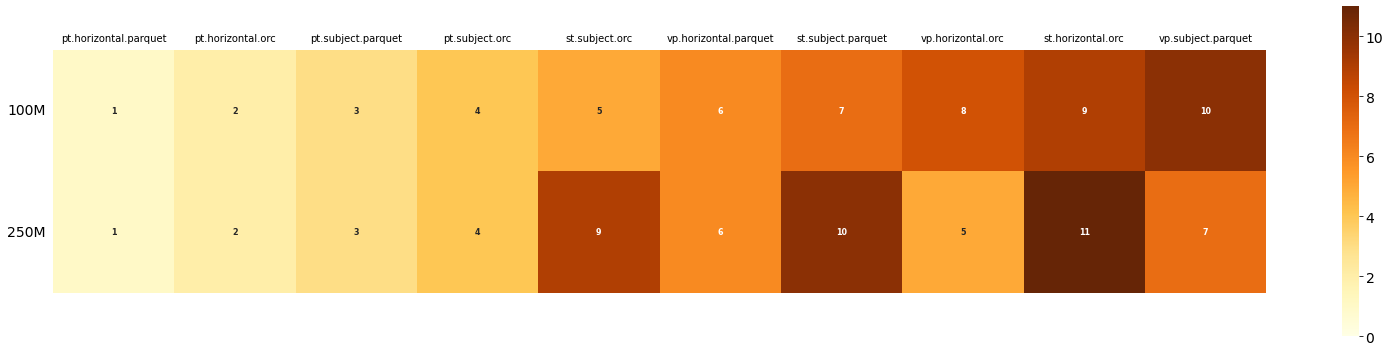

In [50]:
coh.heatMap('100M', "250M", dimension='schemas')

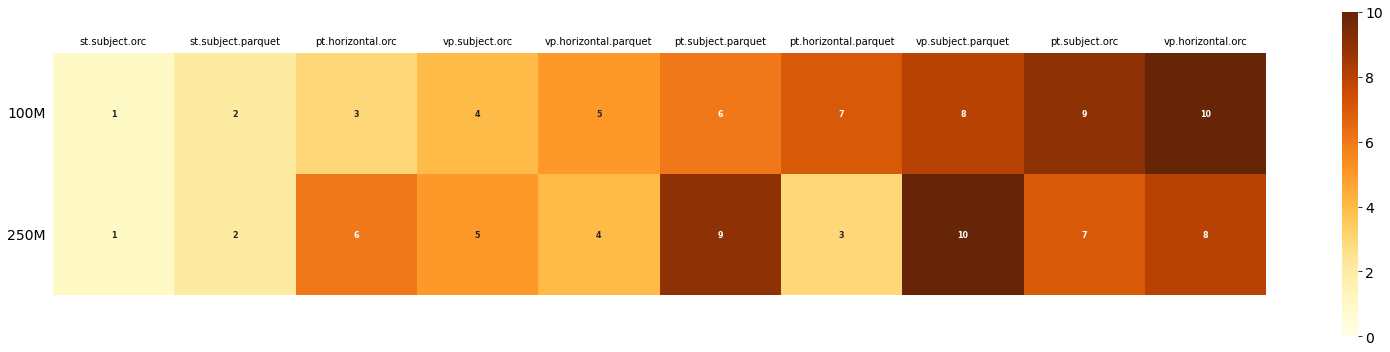

In [51]:
coh.heatMap('100M', "250M", dimension='partition')

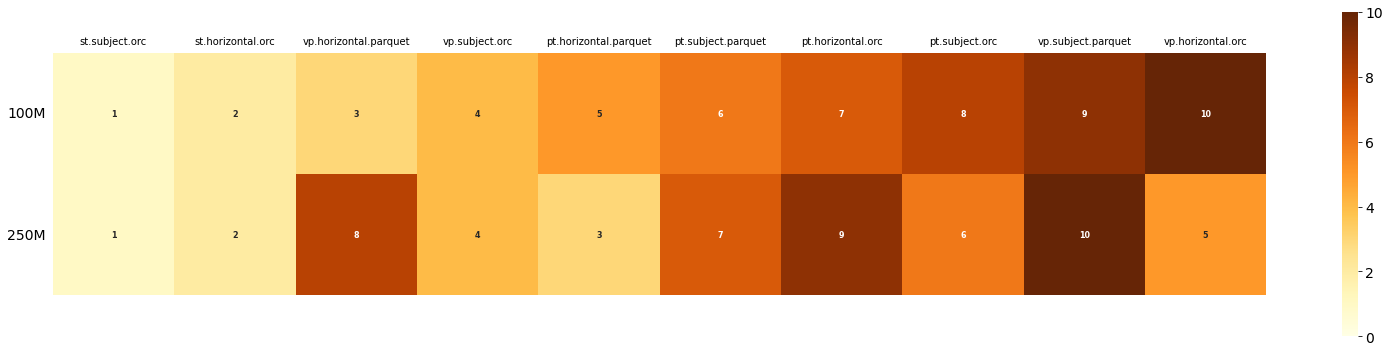

In [52]:
coh.heatMap('100M', "250M", dimension='storage')

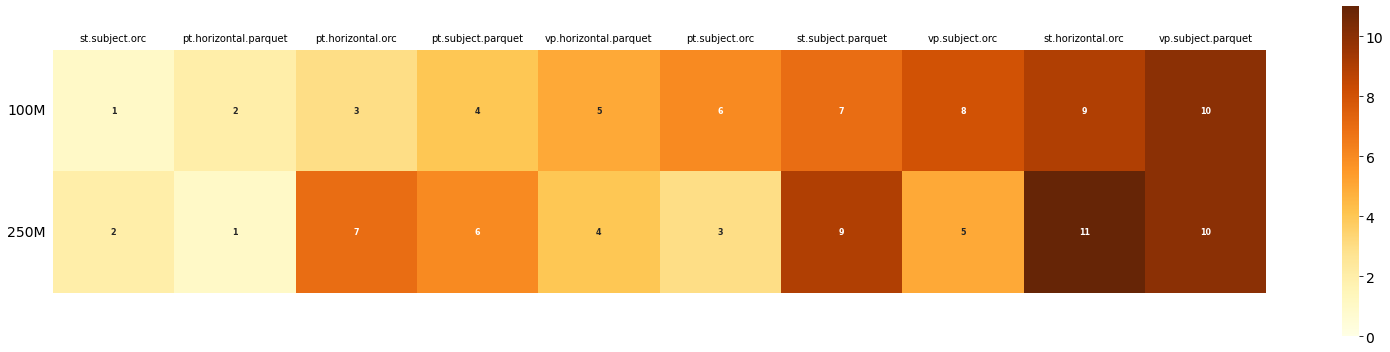

In [61]:
coh.heatMap('100M', "250M", dimension='paretoAgg')

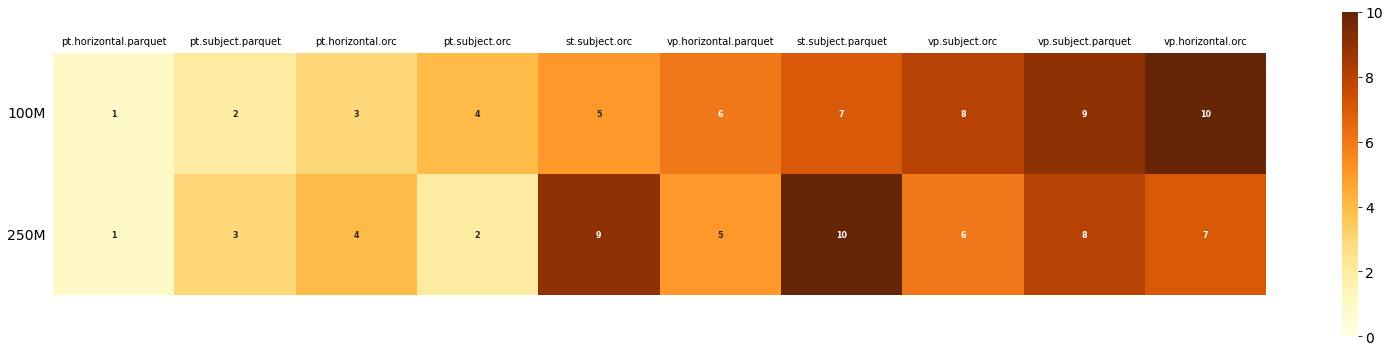

In [54]:
coh.heatMap('100M', "250M", dimension='paretoQ')

### Ranker.Coherence.heatMapSubtract

#### Coherence.<b>heatMap</b>(<i>*args, dimension</i>)
<small>This method shows the coherence differences between two particular ranking sets that user chooses, the first ranking sets will be the pivot point (between 100M-250M, and 100M-500M shown in the example). The heat map will be sorted by the best performing configurations of the first ranking set</small><br><br>
<i>Parameters:</i> <br>
&emsp; <b>*args : str</b><br>
&emsp;&emsp;<small>takes an arbitrary number of ranking sets, the first ranking set will be the pivot point for all the other ranking sets</small><br><br>
&emsp; <b>dimension : str</b><br>
&emsp;&emsp;<small>user's choosen dimension to view the heat map</small><br><br>

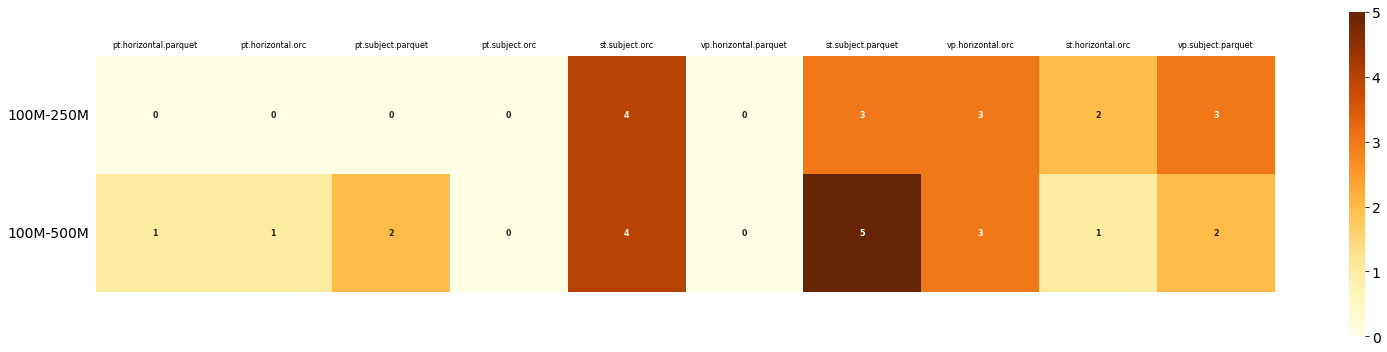

In [55]:
coh.heatMapSubtract('100M', '250M', '500M', dimension='schemas')

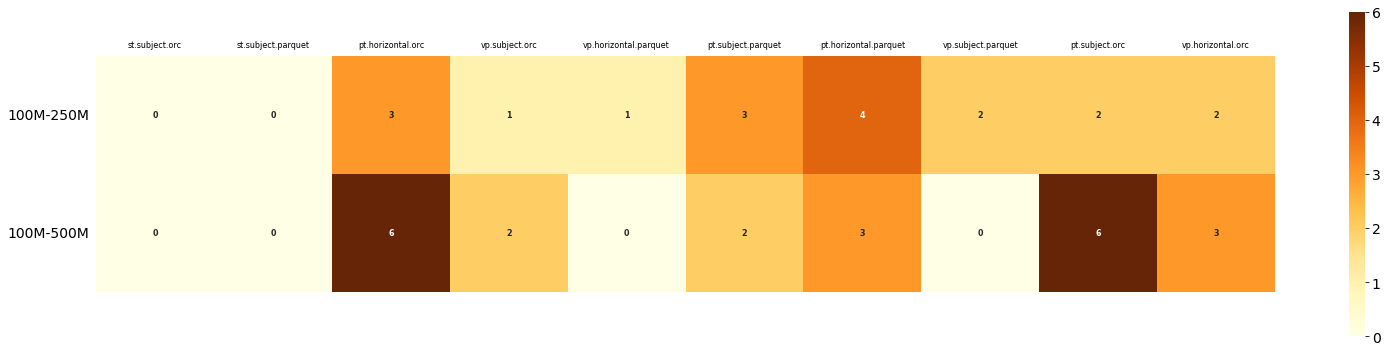

In [56]:
coh.heatMapSubtract('100M', '250M', '500M', dimension='partition')

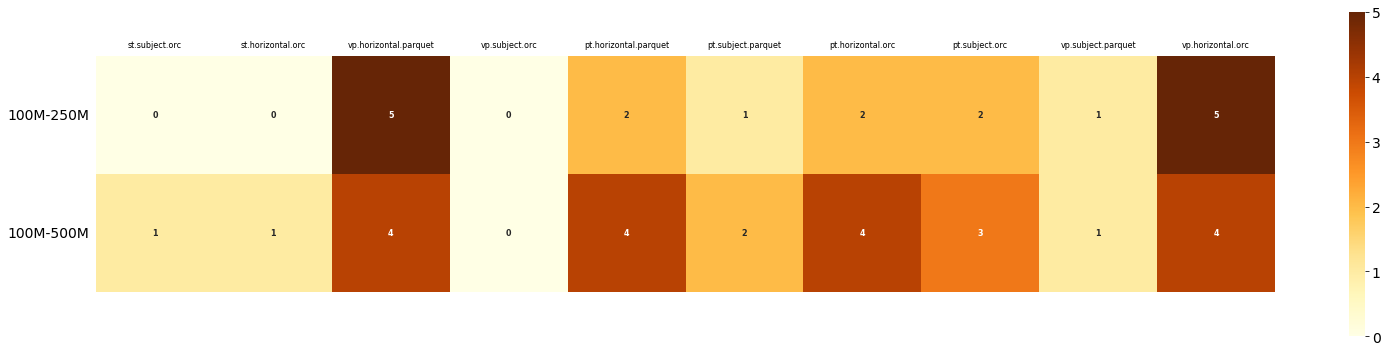

In [57]:
coh.heatMapSubtract('100M', '250M', '500M', dimension='storage')

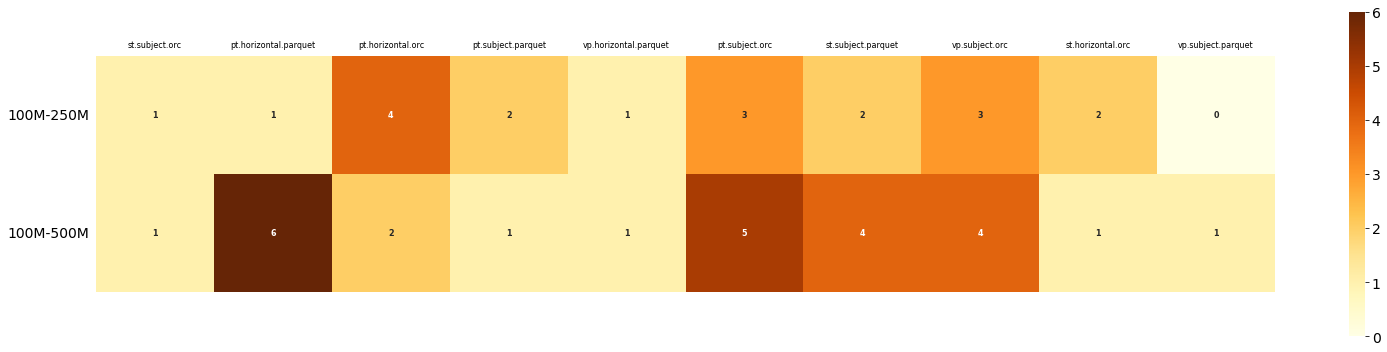

In [58]:
coh.heatMapSubtract('100M', '250M', '500M', dimension='paretoAgg')

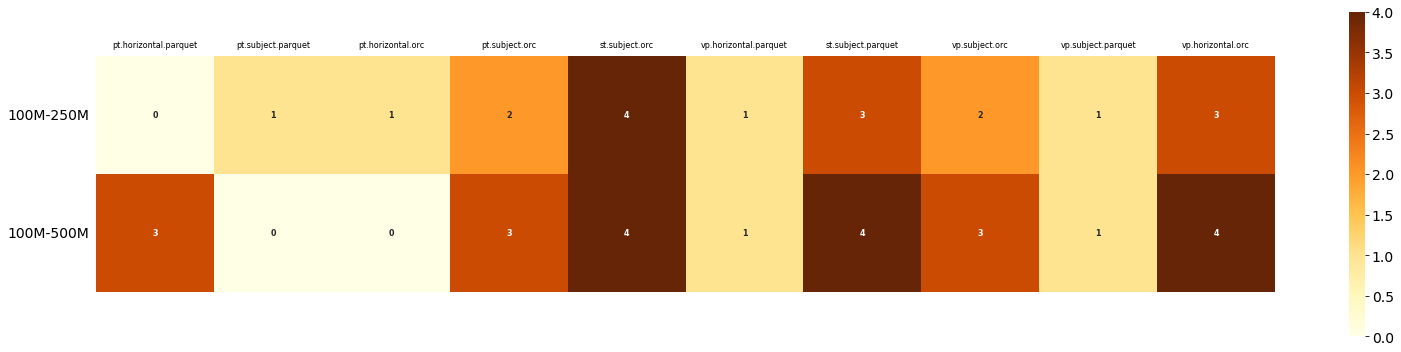

In [59]:
coh.heatMapSubtract('100M', '250M', '500M', dimension='paretoQ')